# 0.0 导入
## 0.1 导入包

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from IPython.display import HTML
from IPython.display import Image

import requests

from sklearn.linear_model import LinearRegression, Lasso

from joblib import dump
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import numpy as np
import inflection
import math

from boruta import BorutaPy
import datetime

## 0.2 评价指标

In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

In [8]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def calculate_rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    rmspe = calculate_rmspe(y, yhat)
    return pd.DataFrame({"MAE": mae,
                         "MAPE": mape,
                         "RMSE": rmse,
                        "RMSPE": rmspe}, index=[model_name])

## 0.3 导入数据

In [10]:
df_sales_train = pd.read_csv("../dataset/train.csv", low_memory=False)
df_store_raw = pd.read_csv("../dataset/store.csv", low_memory=False)
df_sales_test = pd.read_csv("../dataset/test.csv", low_memory=False)

In [11]:
# merge
df_raw_train = pd.merge(df_sales_train, df_store_raw, how="left", on="Store")
df_raw_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
df_raw_train['Store'].value_counts()

Store
1       942
726     942
708     942
709     942
713     942
714     942
715     942
717     942
718     942
720     942
721     942
722     942
723     942
724     942
725     942
727     942
705     942
728     942
729     942
730     942
731     942
732     942
733     942
734     942
735     942
737     942
738     942
740     942
741     942
742     942
707     942
704     942
665     942
685     942
667     942
668     942
672     942
673     942
674     942
675     942
676     942
678     942
679     942
680     942
681     942
682     942
683     942
686     942
703     942
687     942
688     942
689     942
690     942
691     942
692     942
693     942
695     942
696     942
697     942
698     942
699     942
700     942
743     942
745     942
746     942
798     942
784     942
785     942
786     942
787     942
788     942
789     942
790     942
791     942
792     942
793     942
794     942
795     942
796     942
799     942
747     942
800     942
801     94

# 1.0 数据描述

In [13]:
df1=df_raw_train.copy()

## 1.1 列重命名

In [15]:
columns=df1.columns.tolist()
snakecase=lambda x:inflection.underscore(x)
columns_new=list(map(snakecase,columns))

df1.columns=columns_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 数据维度

In [16]:
print('The shape of Rows:{}'.format(df1.shape[0]))
print('The shape of Cols:{}'.format(df1.shape[1]))

The shape of Rows:1017209
The shape of Cols:18


## 1.3 数据格式

In [17]:
df1['date']=pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 检查缺失值

In [18]:
print(df1.isna().mean())

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64


(1) competition_distance存在3个缺失值；且各个门店CompetitionDistance差别较大（最小20，最大75860），使用中位数填充。

In [19]:
df1['competition_distance'] = df1['competition_distance'].fillna(df1['competition_distance'].quantile(0.5))

(2) competition_open_since_month, competition_open_since_year竞争对手开业时间，若有空缺直接填入今天的时间（因为竞争对手开业时间距离现在的时长更重要，填充后后续可以直接相减创建新特征）

In [20]:
df1['competition_open_since_month']=df1['competition_open_since_month'].fillna(df1['date'].dt.month)

In [21]:
df1['competition_open_since_year']=df1['competition_open_since_year'].fillna(df1['date'].dt.year)

(3) 同理promo2_since_week，promo2_since_year

In [23]:
df1['promo2_since_week']=df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week)
df1['promo2_since_year']=df1['promo2_since_year'].fillna(df1['date'].dt.year)

新增is_promo判断在不在促销期

In [24]:
# promo_interval
month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"] = df1["promo_interval"].fillna(0)
df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)

## 1.6 数据格式

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [28]:
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int64)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int64)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int64)

## 1.7 分出数值指标和文本指标

In [29]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

### 1.7.1 数值特征

In [30]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

In [31]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5422.033790,2330.0,7706.909256,2.933466,13.040563
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 标签特征

In [32]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

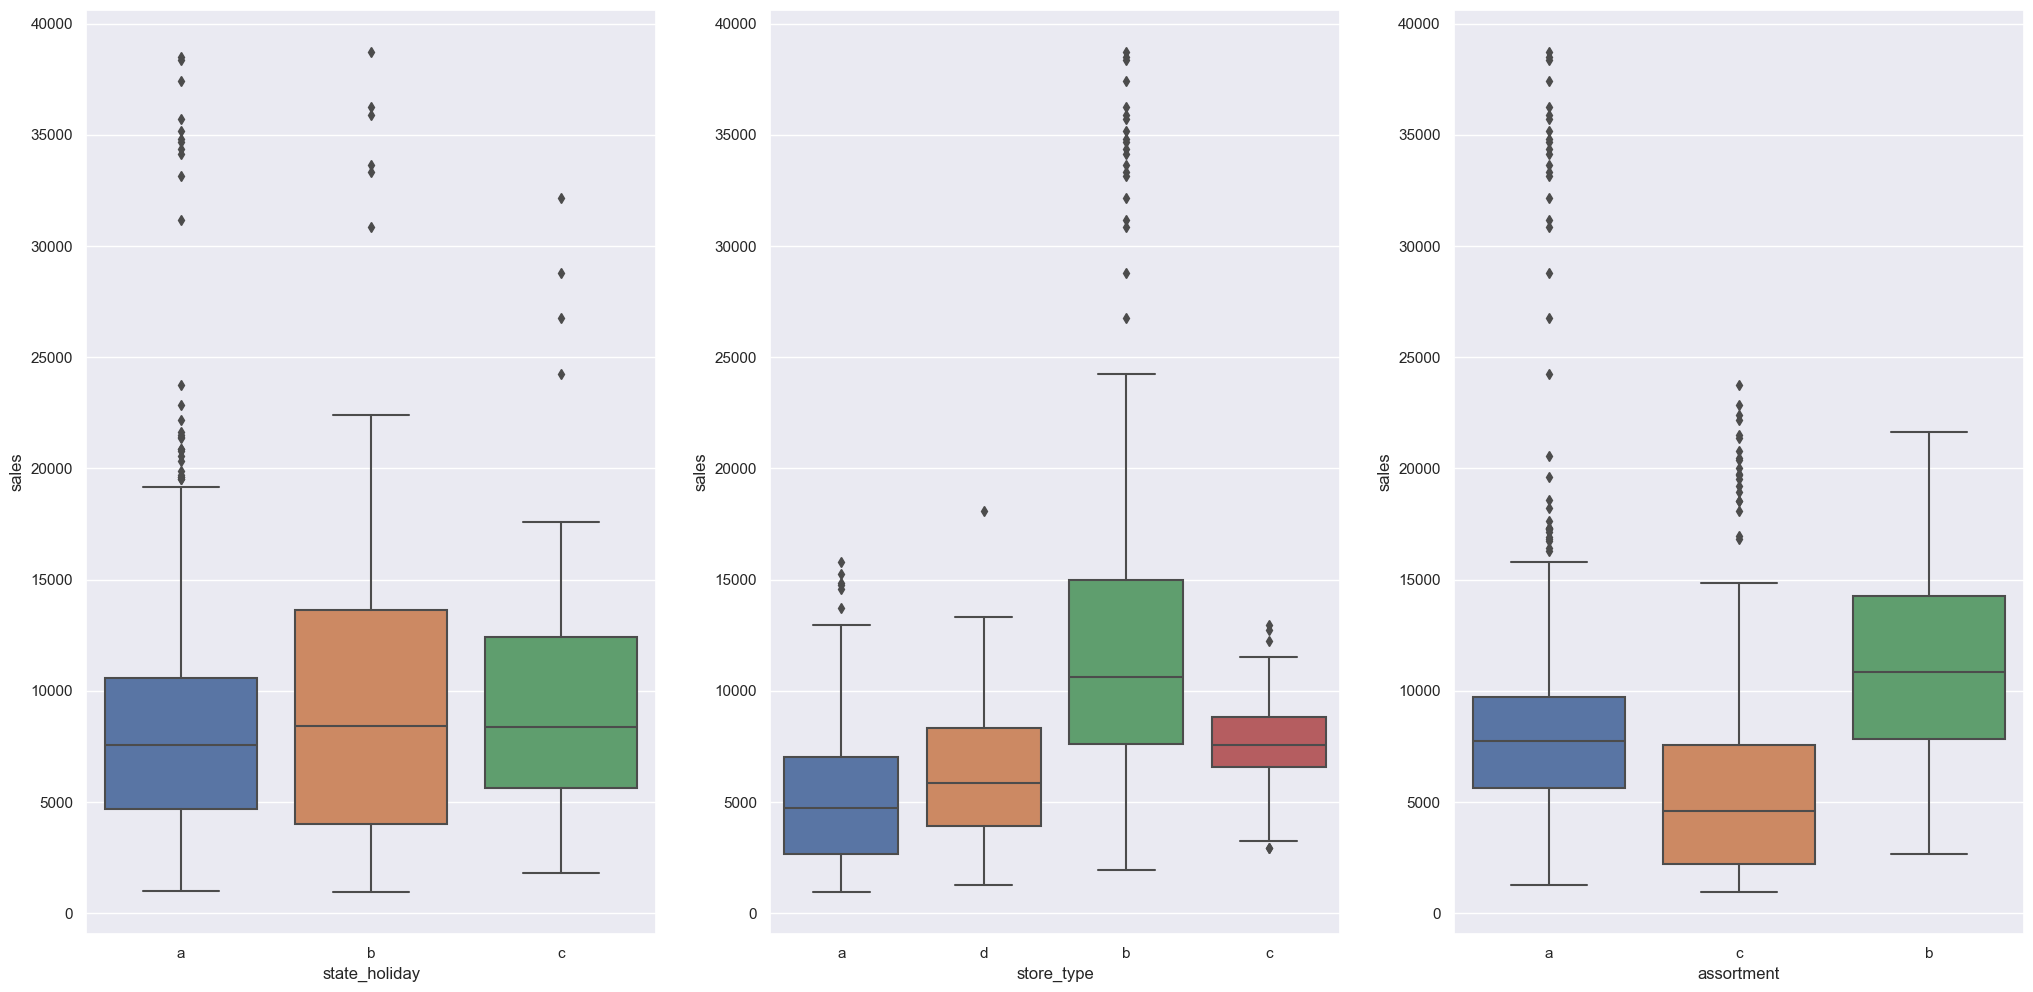

In [33]:
sns.set_style()

data_sales=df1[(df1['sales']>0)&(df1['state_holiday']!='0')]

fig,axes=subplots(1,3)

sns.boxplot(x="state_holiday", y="sales", data=data_sales, ax=axes[0])
sns.boxplot(x="store_type", y="sales", data=data_sales, ax=axes[1])
sns.boxplot(x="assortment", y="sales", data=data_sales, ax=axes[2])

# 2.0 特征工程

In [34]:
df2 = df1.copy()

## 2.1 合理假设

1. 商品种类更多的商店应该卖得更多。

2. 竞争对手更近的商店应该卖得更少。

3. 竞争对手存在时间更长的商店应该卖得更多。

4. 活动促销时间更长的商店应该卖得更多。

5. 促销天数更多的商店应该卖得更多。

6. 连续促销次数更多的商店应该卖得更多。

7. 在圣诞假期开放的商店应该卖得更多。

8. 商店的销售额应该随着时间的推移而增加。

9. 商店在一年中的第二个季度应该卖得更多。

10. 商店在每个月的10号之后应该卖得更多。

11. 商店在周末的销售额应该更少。

12. 商店在学校假期期间的销售额应该更少。

## 2.2 特征工程

（1） 从日期中提取年月日

In [35]:
# year
df2["year"] = df2["date"].dt.year
# month
df2["month"] = df2["date"].dt.month
# day
df2["day"] = df2["date"].dt.day
# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week
# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

（2） 竞争时间间隔 （已知年月，日设置为第一天）

In [36]:
# competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)

df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

（3） 促销时间间隔 （已知年和第几周，日设置为第一天）

减去7天的原因是：

促销准备期：假设促销活动通常是在实际开始的前一周就已经开始宣传和准备。通过将促销开始日期设置为前一周，可以更好地反映促销的准备和宣传期。

销售影响分析：在分析销售数据时，如果只考虑促销的第一天，那么在促销活动开始前一周的销售数据（如用户对促销的反应、预热效果等）就会被忽略。因此，将促销开始日期设置为前一周有助于更全面地评估促销效果。

In [37]:
# promo sence
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)

df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))

df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)

In [38]:
print(df2[["date", "promo2_since_year","promo2_since_week", "promo_since", "promo_time_week"]].tail(10))

              date  promo2_since_year  promo2_since_week promo_since  promo_time_week
1017199 2013-01-01               2013                 31  2013-07-29              -30
1017200 2013-01-01               2010                 13  2010-03-22              145
1017201 2013-01-01               2013                  1  2012-12-31                0
1017202 2013-01-01               2012                 22  2012-05-21               32
1017203 2013-01-01               2013                  1  2012-12-31                0
1017204 2013-01-01               2013                 31  2013-07-29              -30
1017205 2013-01-01               2013                  1  2012-12-31                0
1017206 2013-01-01               2013                  1  2012-12-31                0
1017207 2013-01-01               2013                  1  2012-12-31                0
1017208 2013-01-01               2012                 22  2012-05-21               32


（3） assortation等调整为易于理解的文本分类标签

In [39]:
# assortment
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")
# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 剔除变量
## 3.1 剔除行

In [40]:
df3 = df2.copy()
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

In [41]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.2 剔除列

In [42]:
df3 = df3.drop([ "open", "promo_interval", "month_map"], axis=1)

# 4.0 EDA

In [43]:
df4=df3.copy()

## 4.1 单变量分析

### 4.1.1 响应变量

D:\Programme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


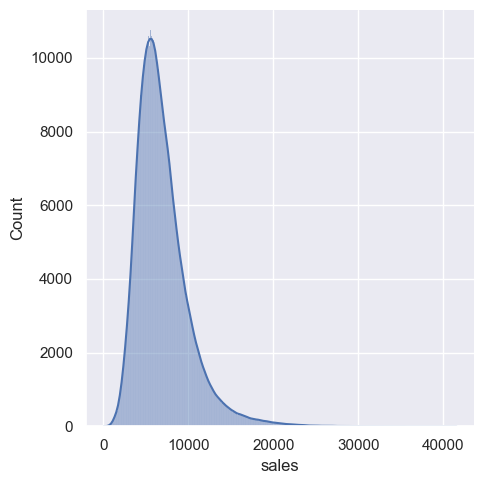

In [44]:
sns.displot(df4["sales"], kde=True)

### 4.1.2 数值变量

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

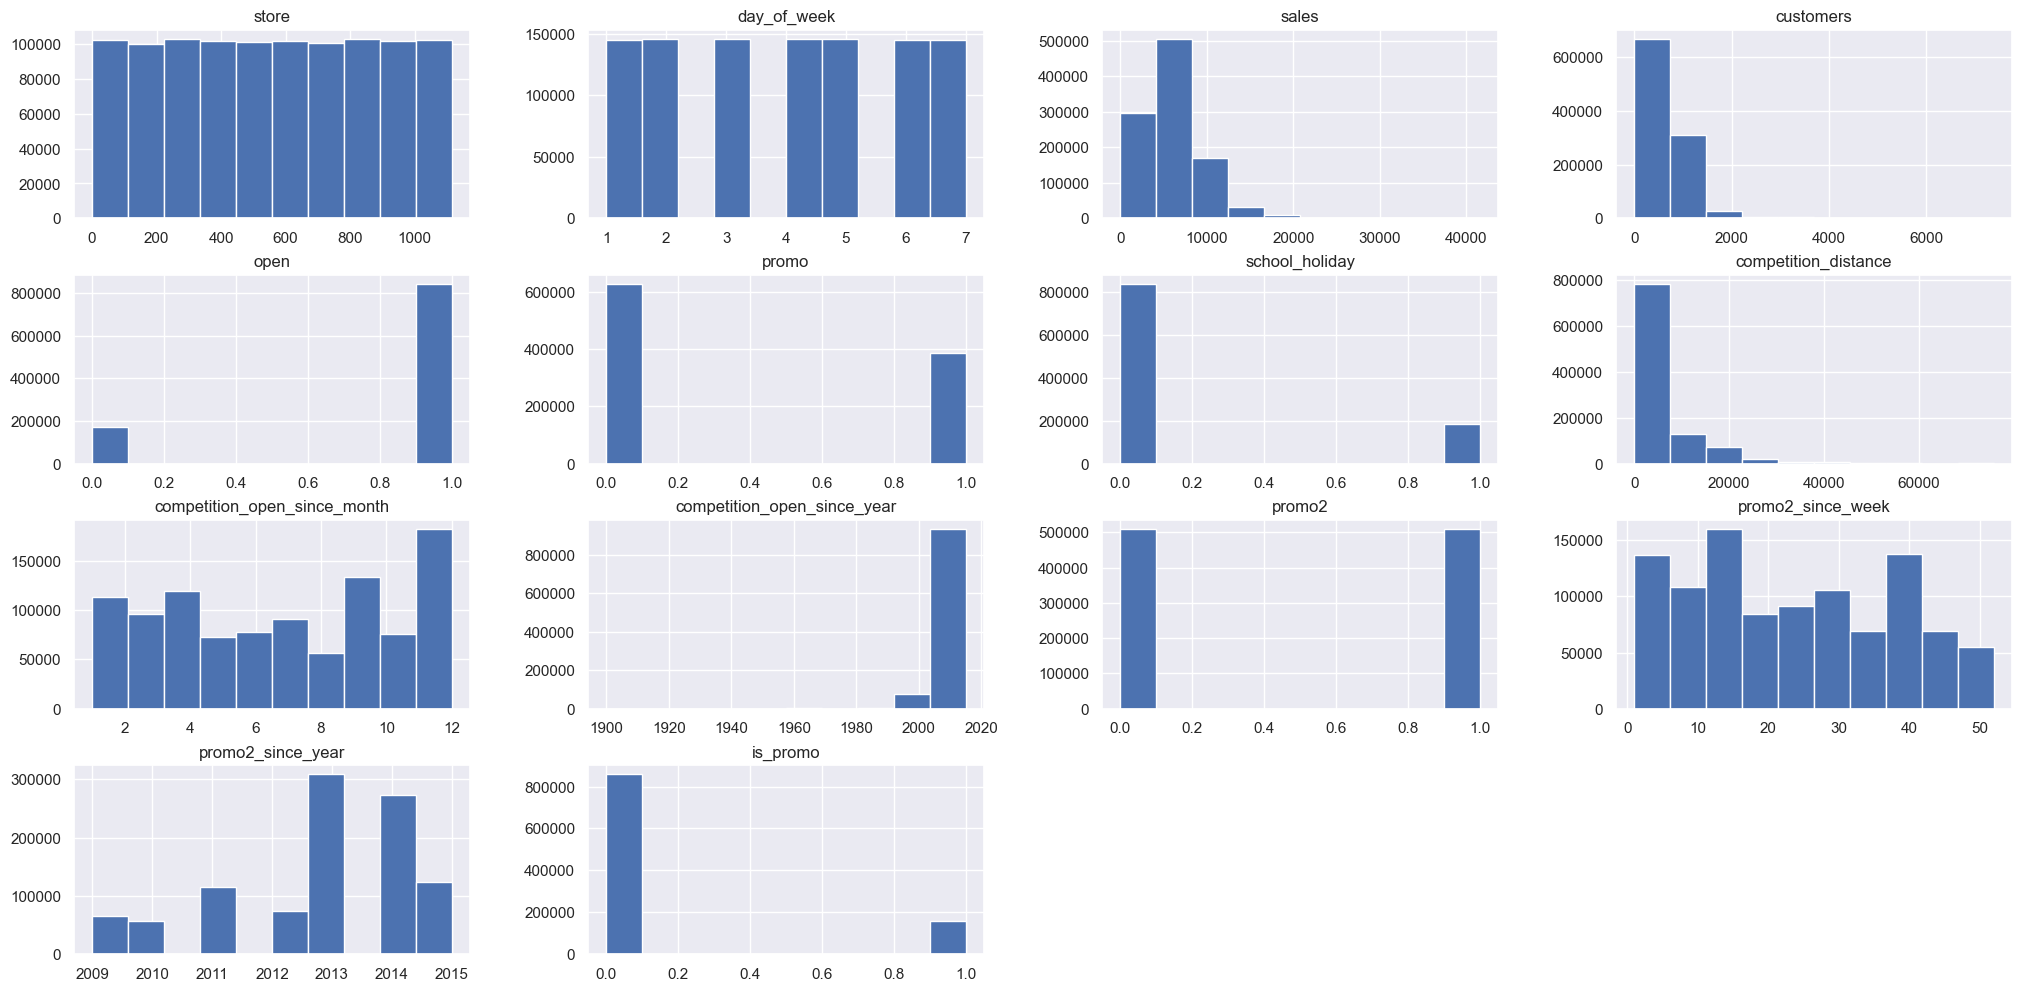

In [46]:
num_attributes.hist()

### 4.1.3 分类变量

C:\Users\kong\AppData\Local\Temp\ipykernel_36580\717802300.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True)
D:\Programme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kong\AppData\Local\Temp\ipykernel_36580\717802300.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True)
D:\Programme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: 

<Axes: xlabel='sales', ylabel='Density'>

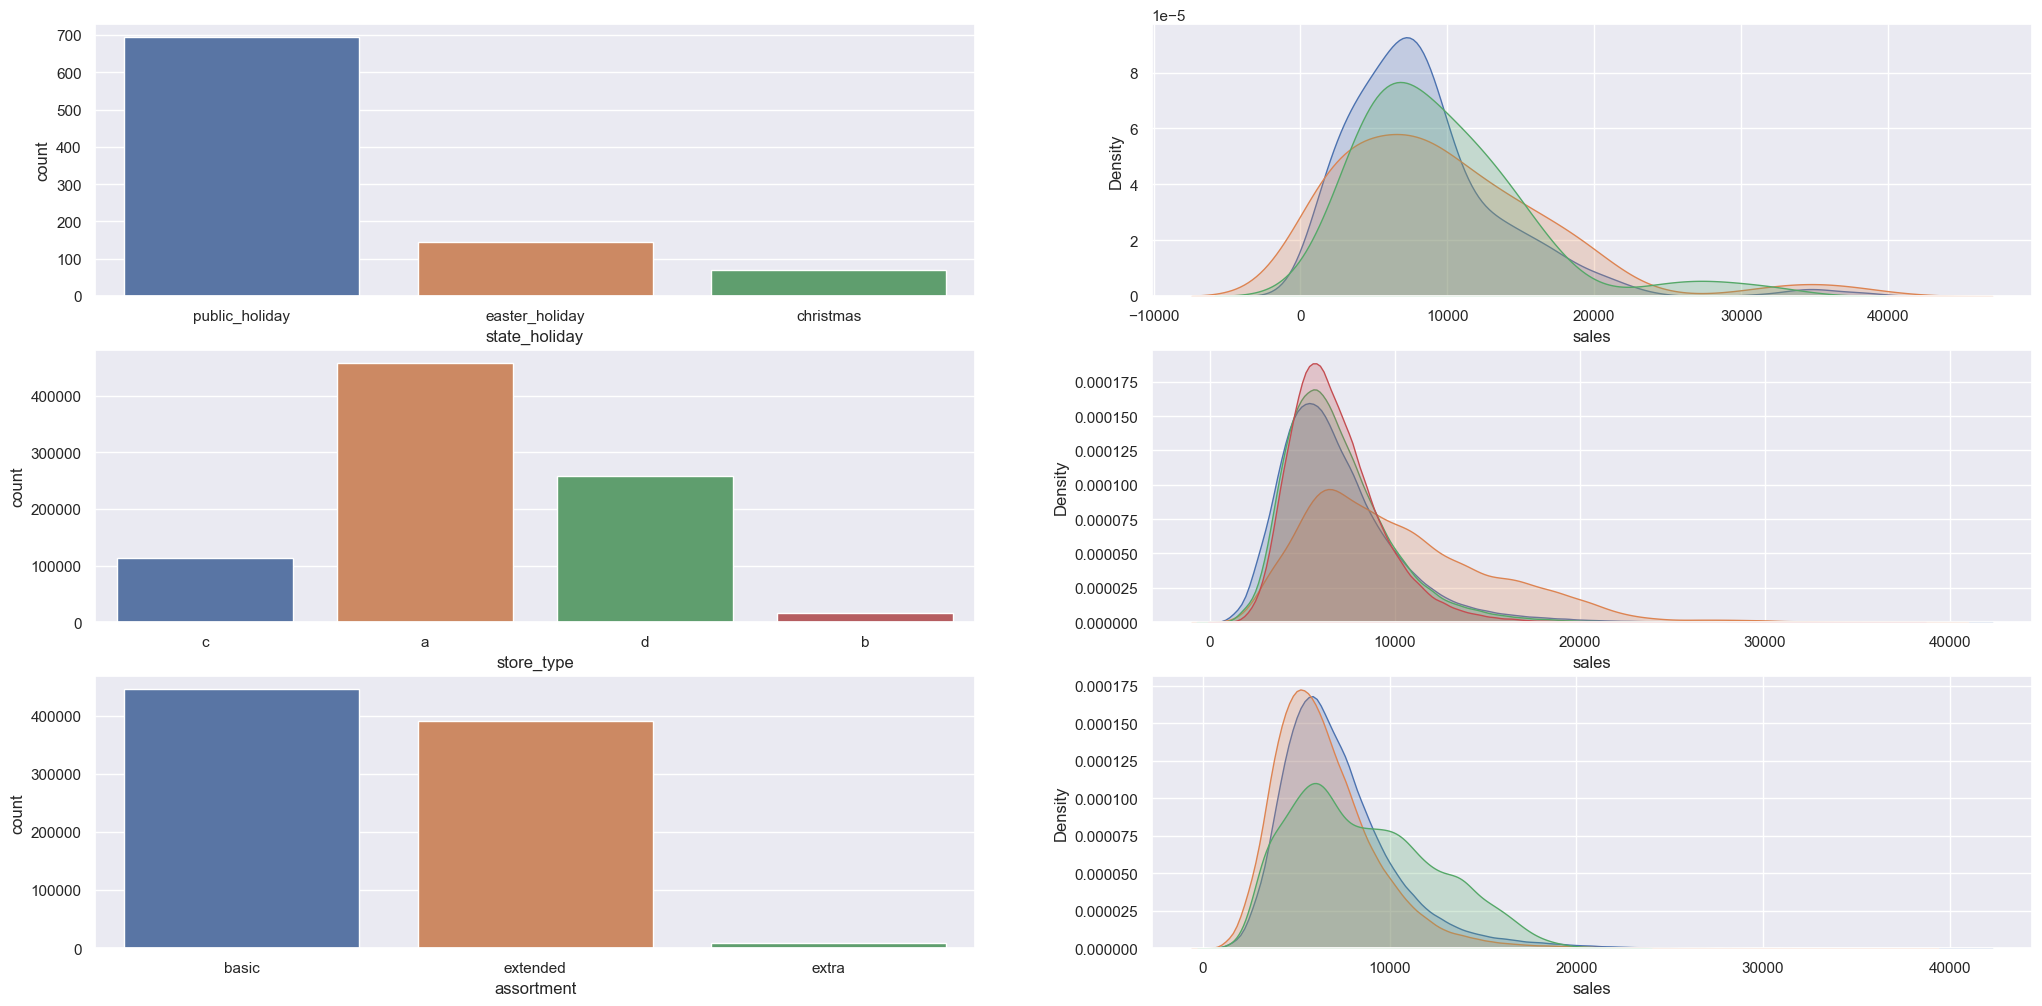

In [47]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(data=a, x="state_holiday")

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x="store_type")

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="c", shade=True)  # 修正为 "c"
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="d", shade=True)  # 修正为 "d"

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(data=df4, x="assortment")

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)


## 4.2 验证假设

#### H1: 产品种类更多的商店应该卖得更多（√）

<Axes: xlabel='year_week'>

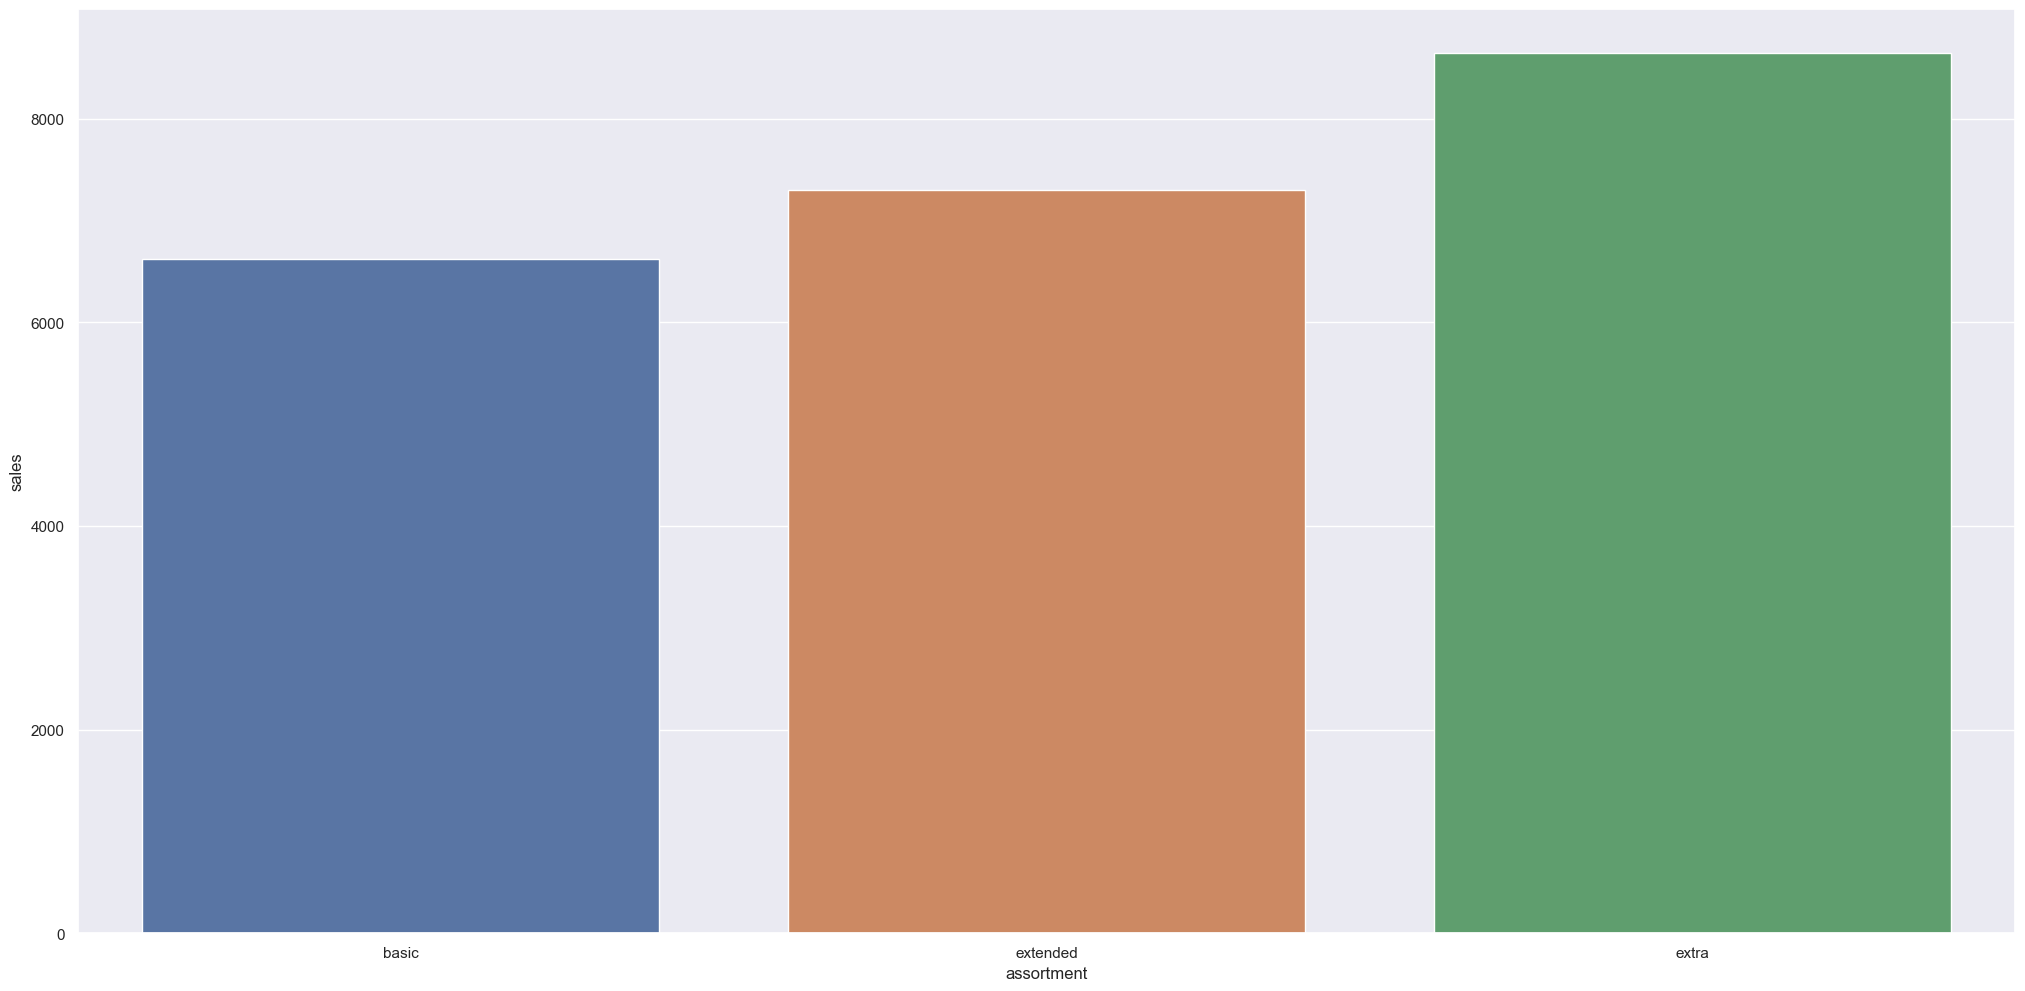

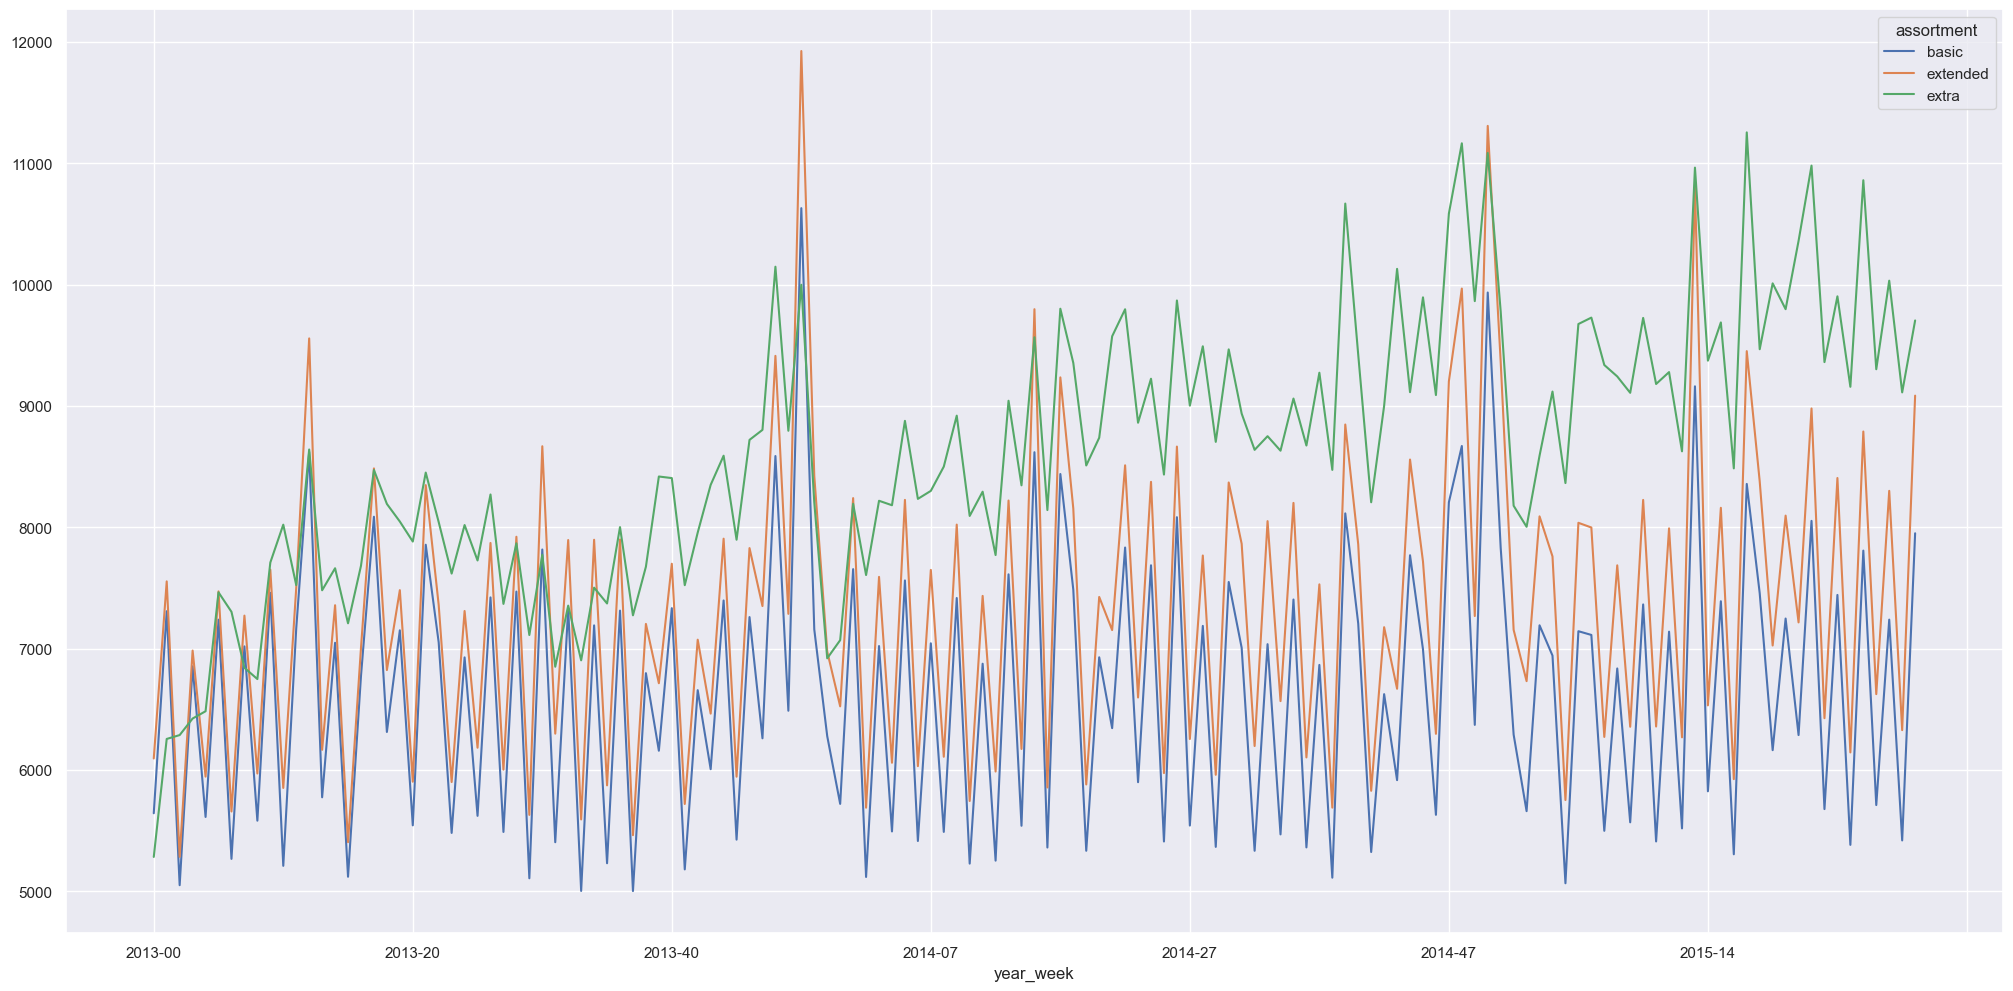

In [48]:
aux1 = df4[["assortment", "sales"]].groupby("assortment").mean().reset_index()
sns.barplot(x="assortment", y="sales", data=aux1)

aux2 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).mean().reset_index()
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

<Figure size 1000x600 with 0 Axes>

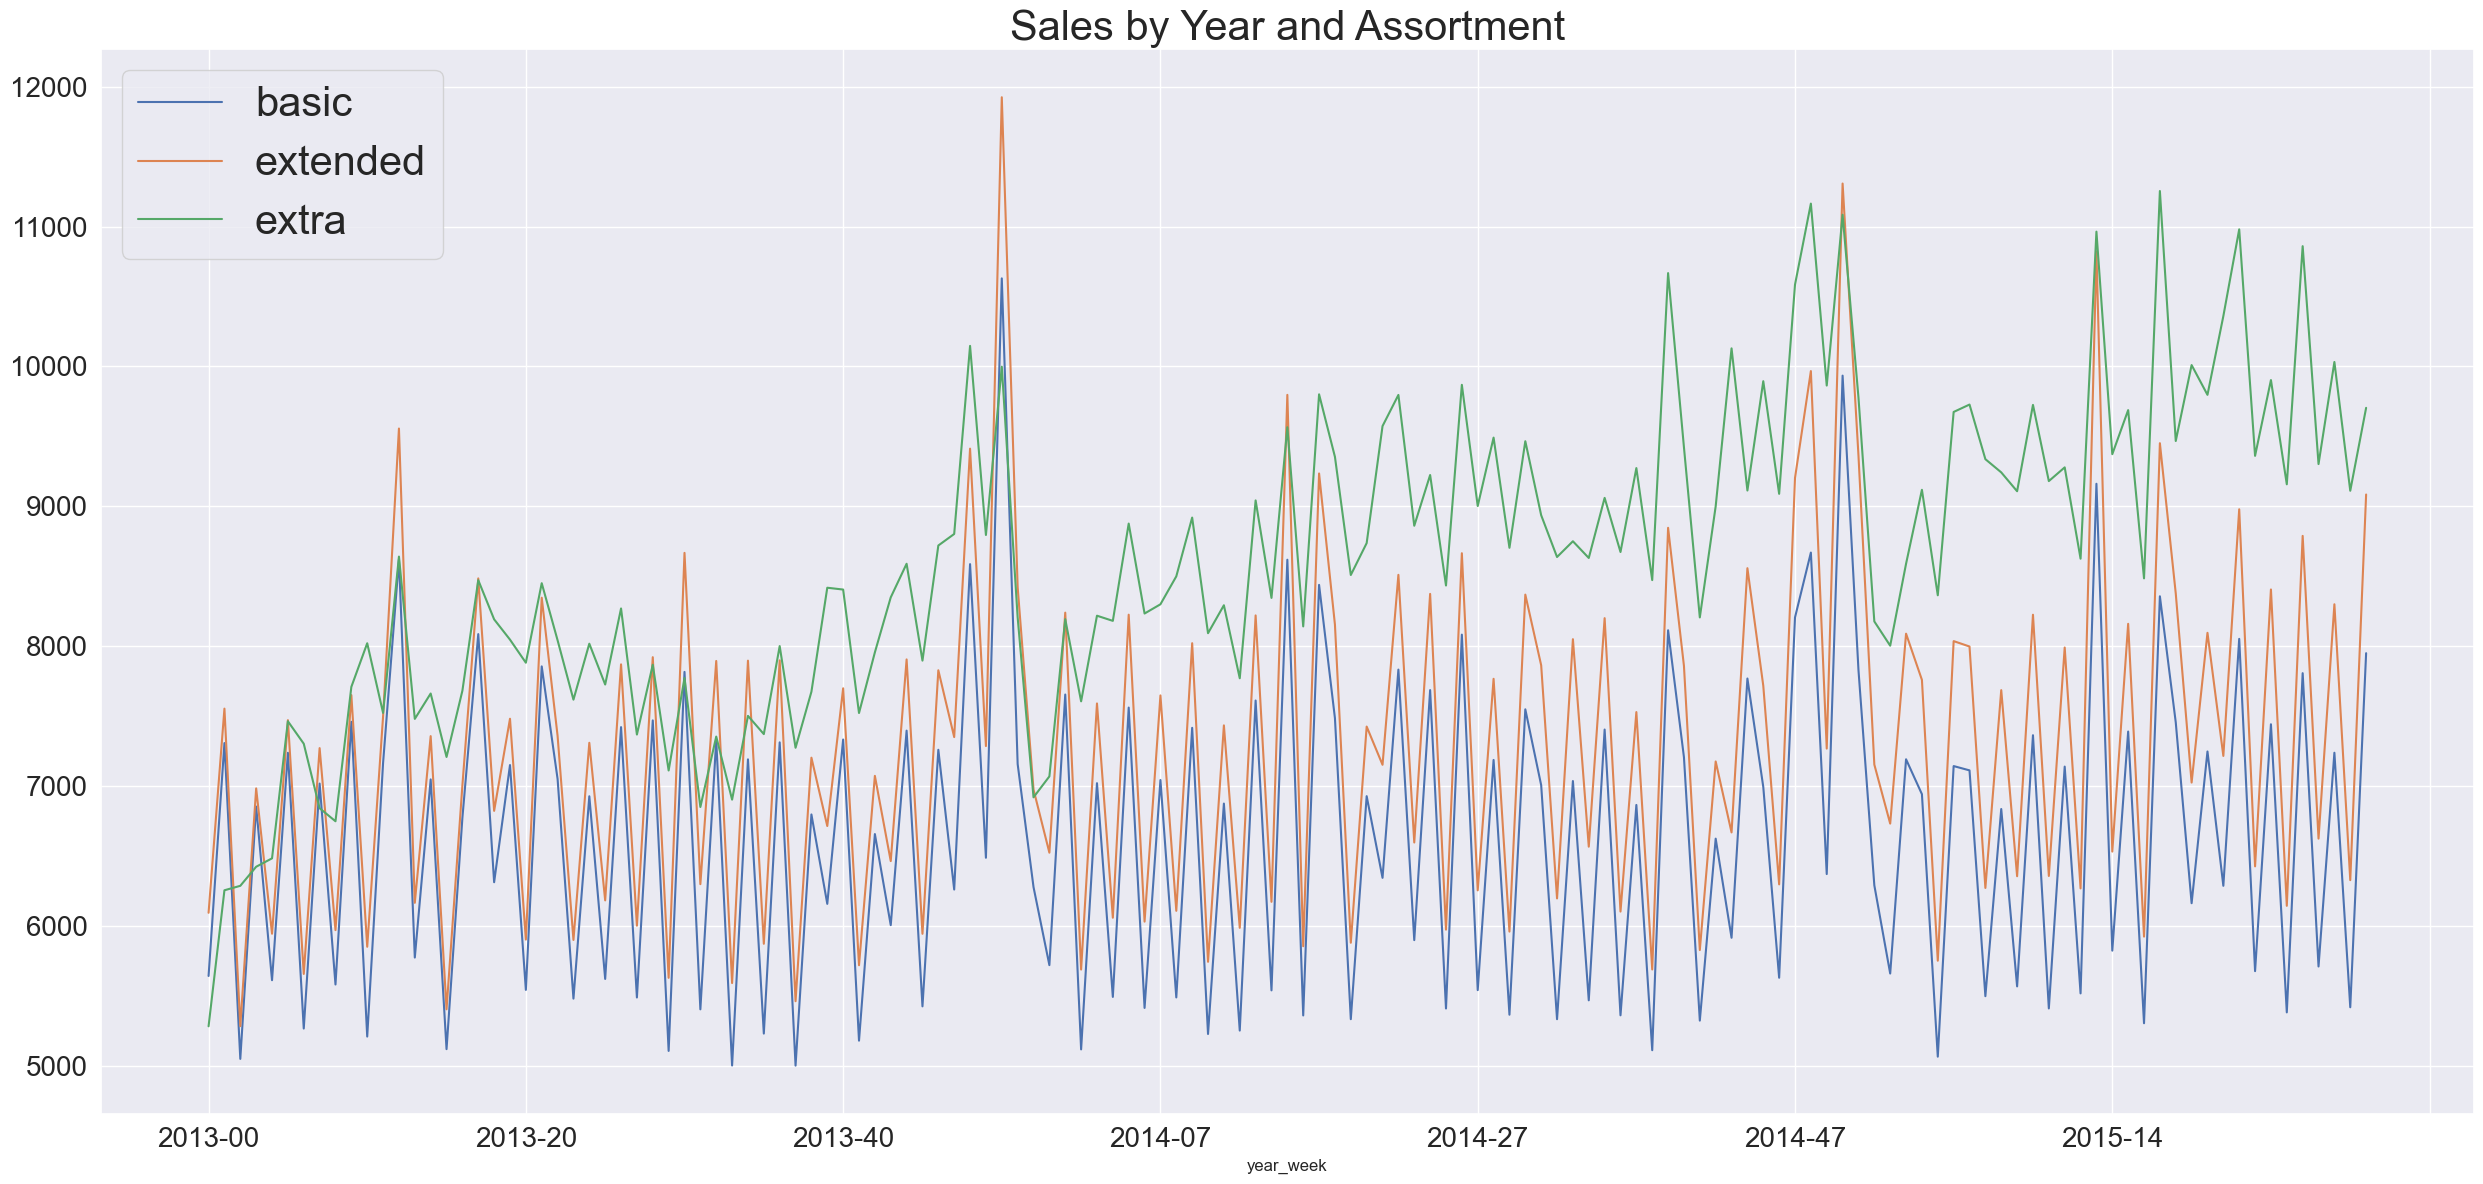

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表大小和字体
plt.figure(figsize=(10, 6))

# 绘制第二个折线图
aux2 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).mean().reset_index()
ax2 = aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

# 设置x轴和y轴标签的字体大小
plt.xticks(fontsize=20)  # 设置x轴标签字体大小
plt.yticks(fontsize=20)  # 设置y轴标签字体大小

# 设置标题字体大小
ax2.set_title("Sales by Year and Assortment", fontsize=30)
# 修改图例字体大小
ax2.legend(fontsize=30)  # 设置图例字体大小
# 调整布局，防止标签被遮挡
plt.tight_layout()

# 显示图形
plt.show()

三种类型的店铺销售额趋势大致相同，但平均销售额呈现：basic < extended < extra

#### H2:距离竞争对手越近，销售额越低（x）

C:\Users\kong\AppData\Local\Temp\ipykernel_36580\3467121624.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").mean().reset_index()
D:\Programme\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


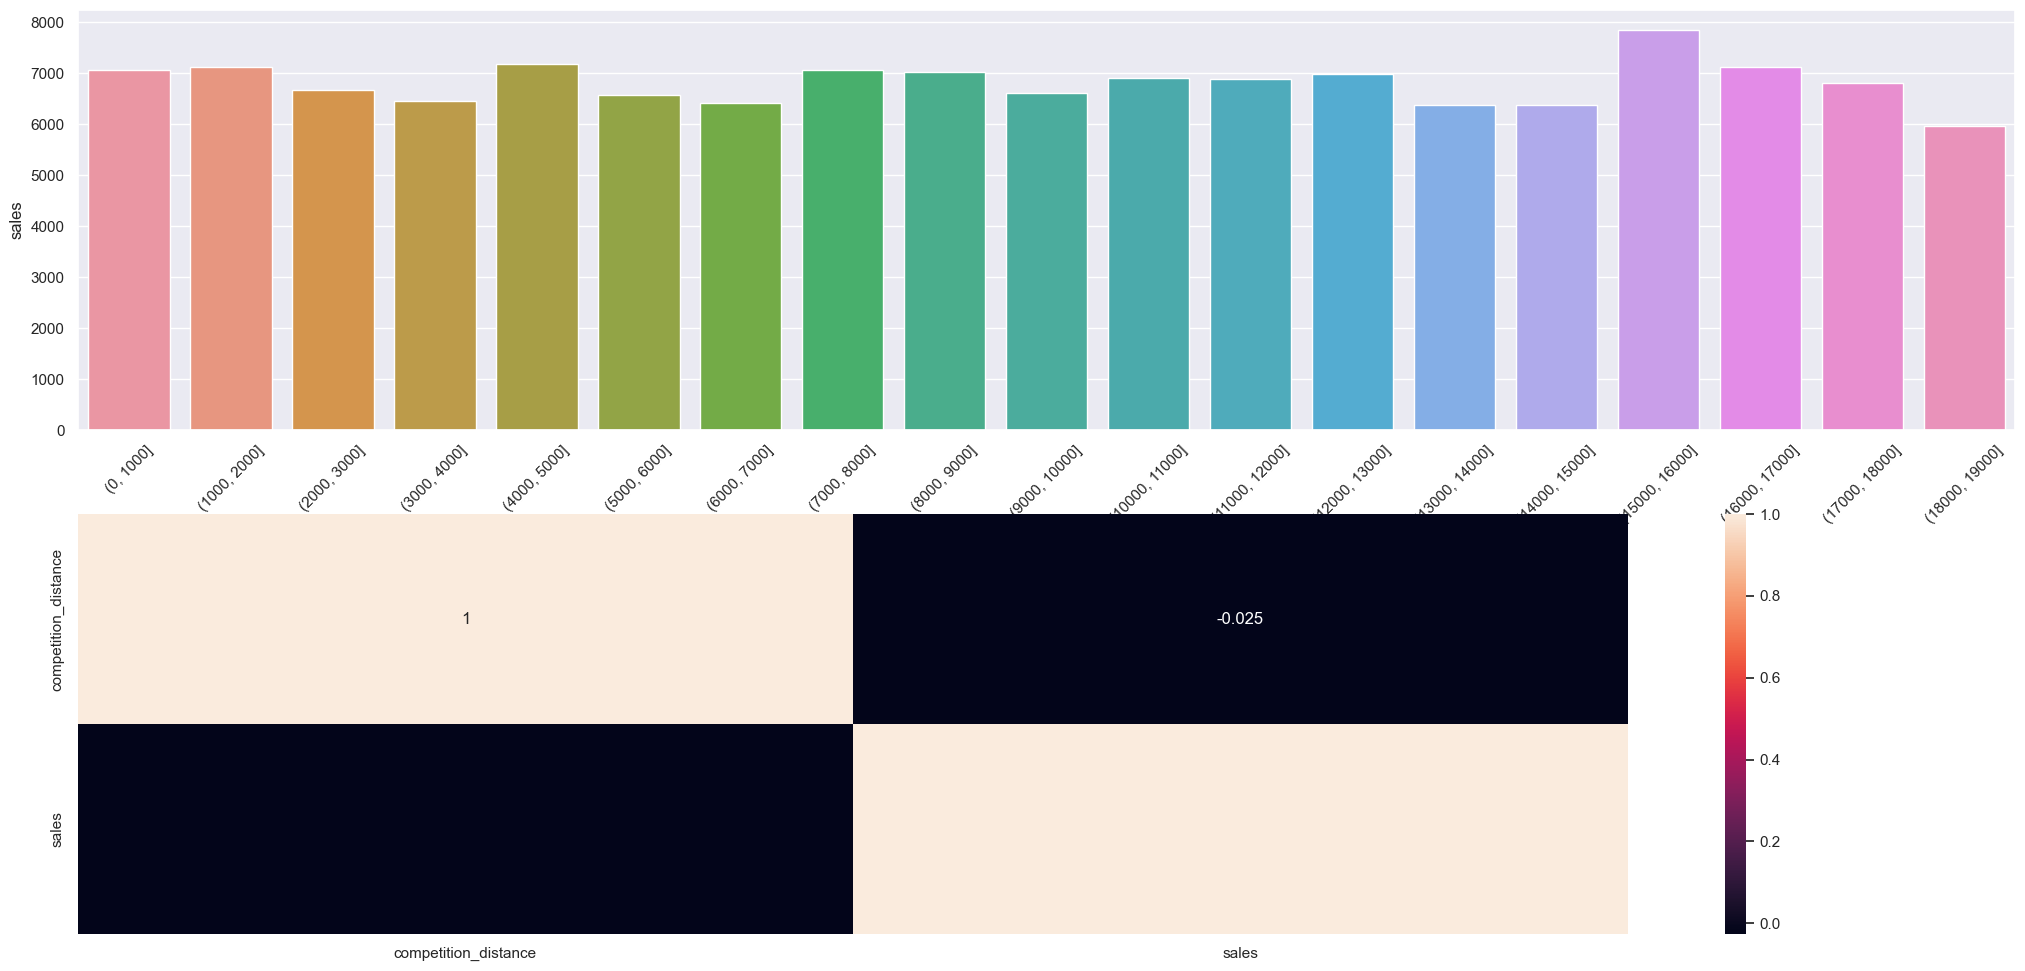

In [50]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").mean().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").mean().reset_index()

plt.subplot(2, 1, 1)
#sns.barplot(x="competition_distance", y="sales", data=aux1);
sns.barplot(x="competition_distance_binned", y="sales", data=aux2);
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
# 只选择数值型列计算相关性
aux1_numeric = aux1.select_dtypes(include=[np.number])
sns.heatmap(aux1_numeric.corr(method="pearson"), annot=True)

plt.show()

<Axes: xlabel='competition_distance', ylabel='sales'>

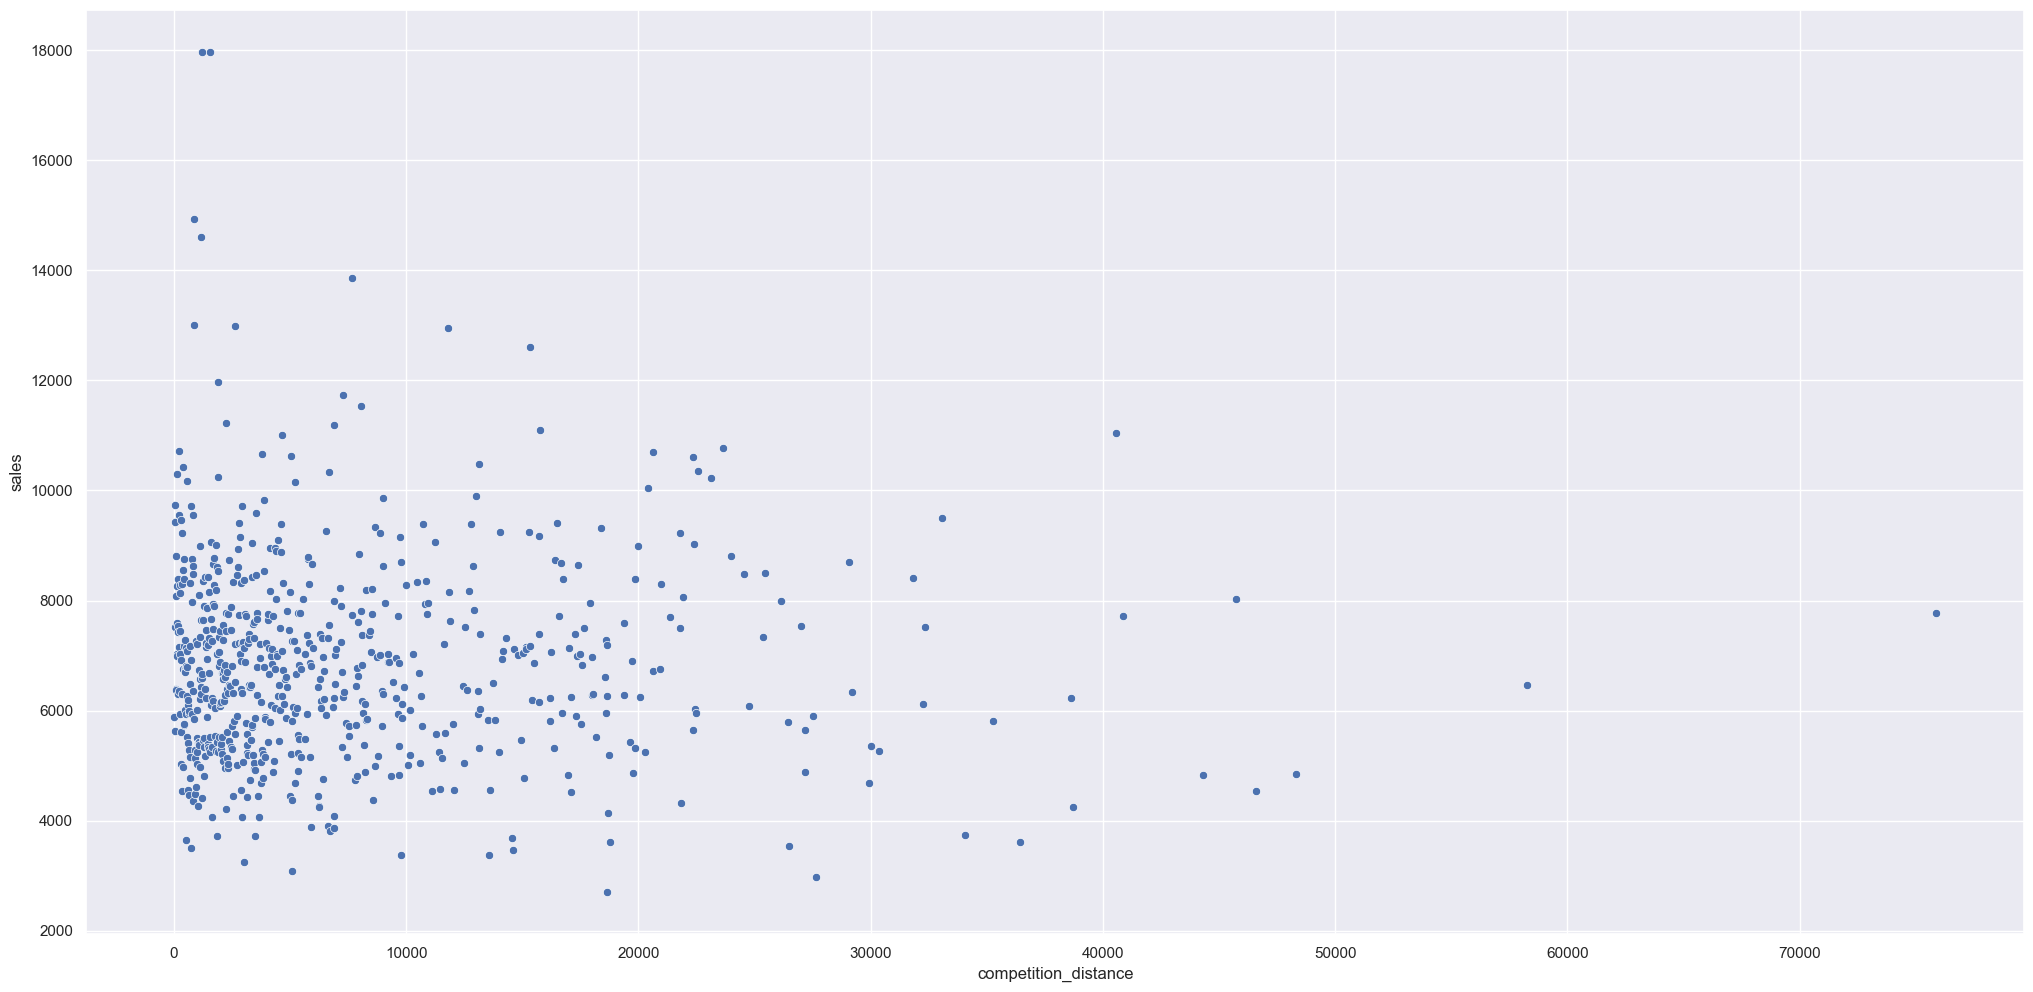

In [51]:
# 计算每个竞争距离下的平均销售额
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").mean().reset_index()

# 绘制竞争距离与销售额的散点图
sns.scatterplot(x="competition_distance", y="sales", data=aux1)

看起来没有特别大的影响

#### H3：竞争对手存在时间更长的商店应该卖得更多(x)

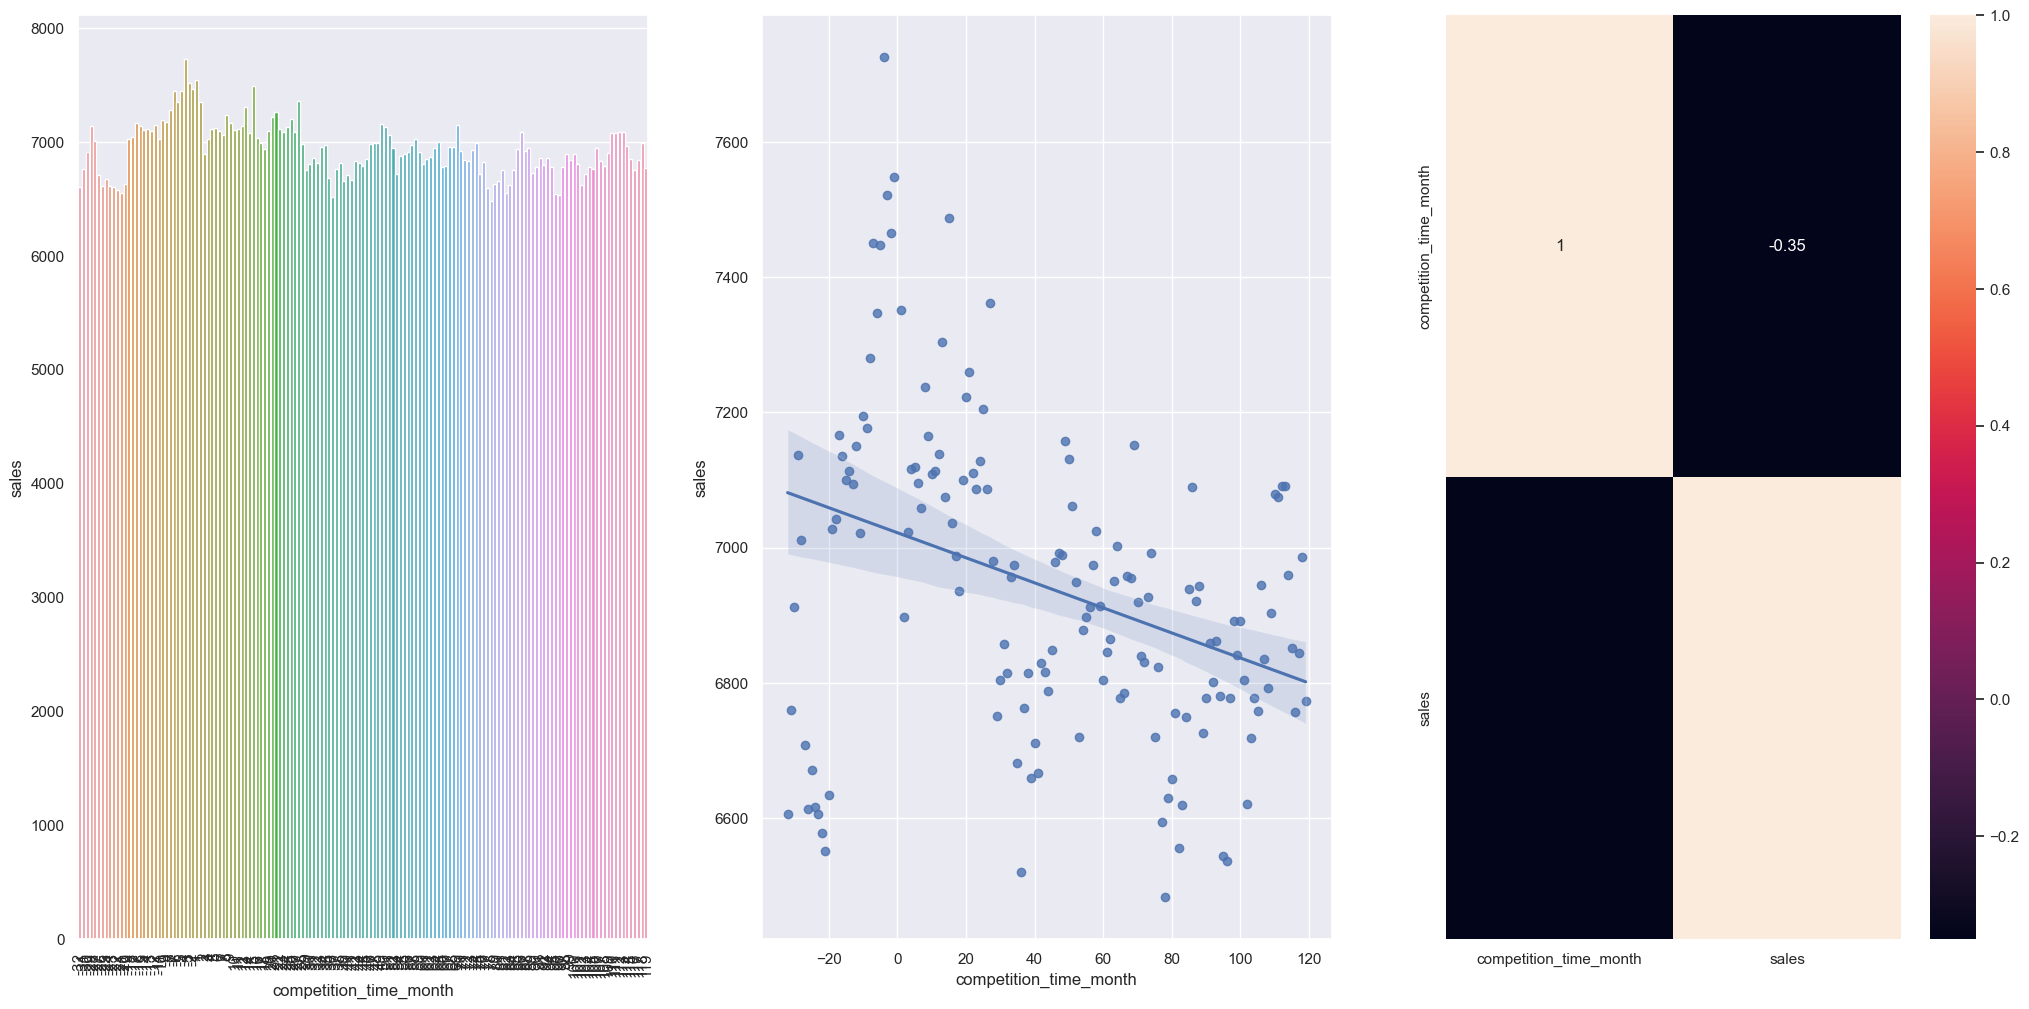

In [52]:
plt.subplot(1, 3, 1)
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").mean().reset_index()
# 只选择 competition_time_month 小于 120 个月且不等于 0 的数据，避免时间太长或无竞争者的情况
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(), annot=True);

C:\Users\kong\AppData\Local\Temp\ipykernel_36580\2389590854.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2["competition_time_month_binned"] = pd.cut(aux2["competition_time_month"], bins=bins)
C:\Users\kong\AppData\Local\Temp\ipykernel_36580\2389590854.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux3 = aux2[["competition_time_month_binned", "sales"]].groupby("competition_time_month_binned").mean().reset_index()
D:\Programme\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated an

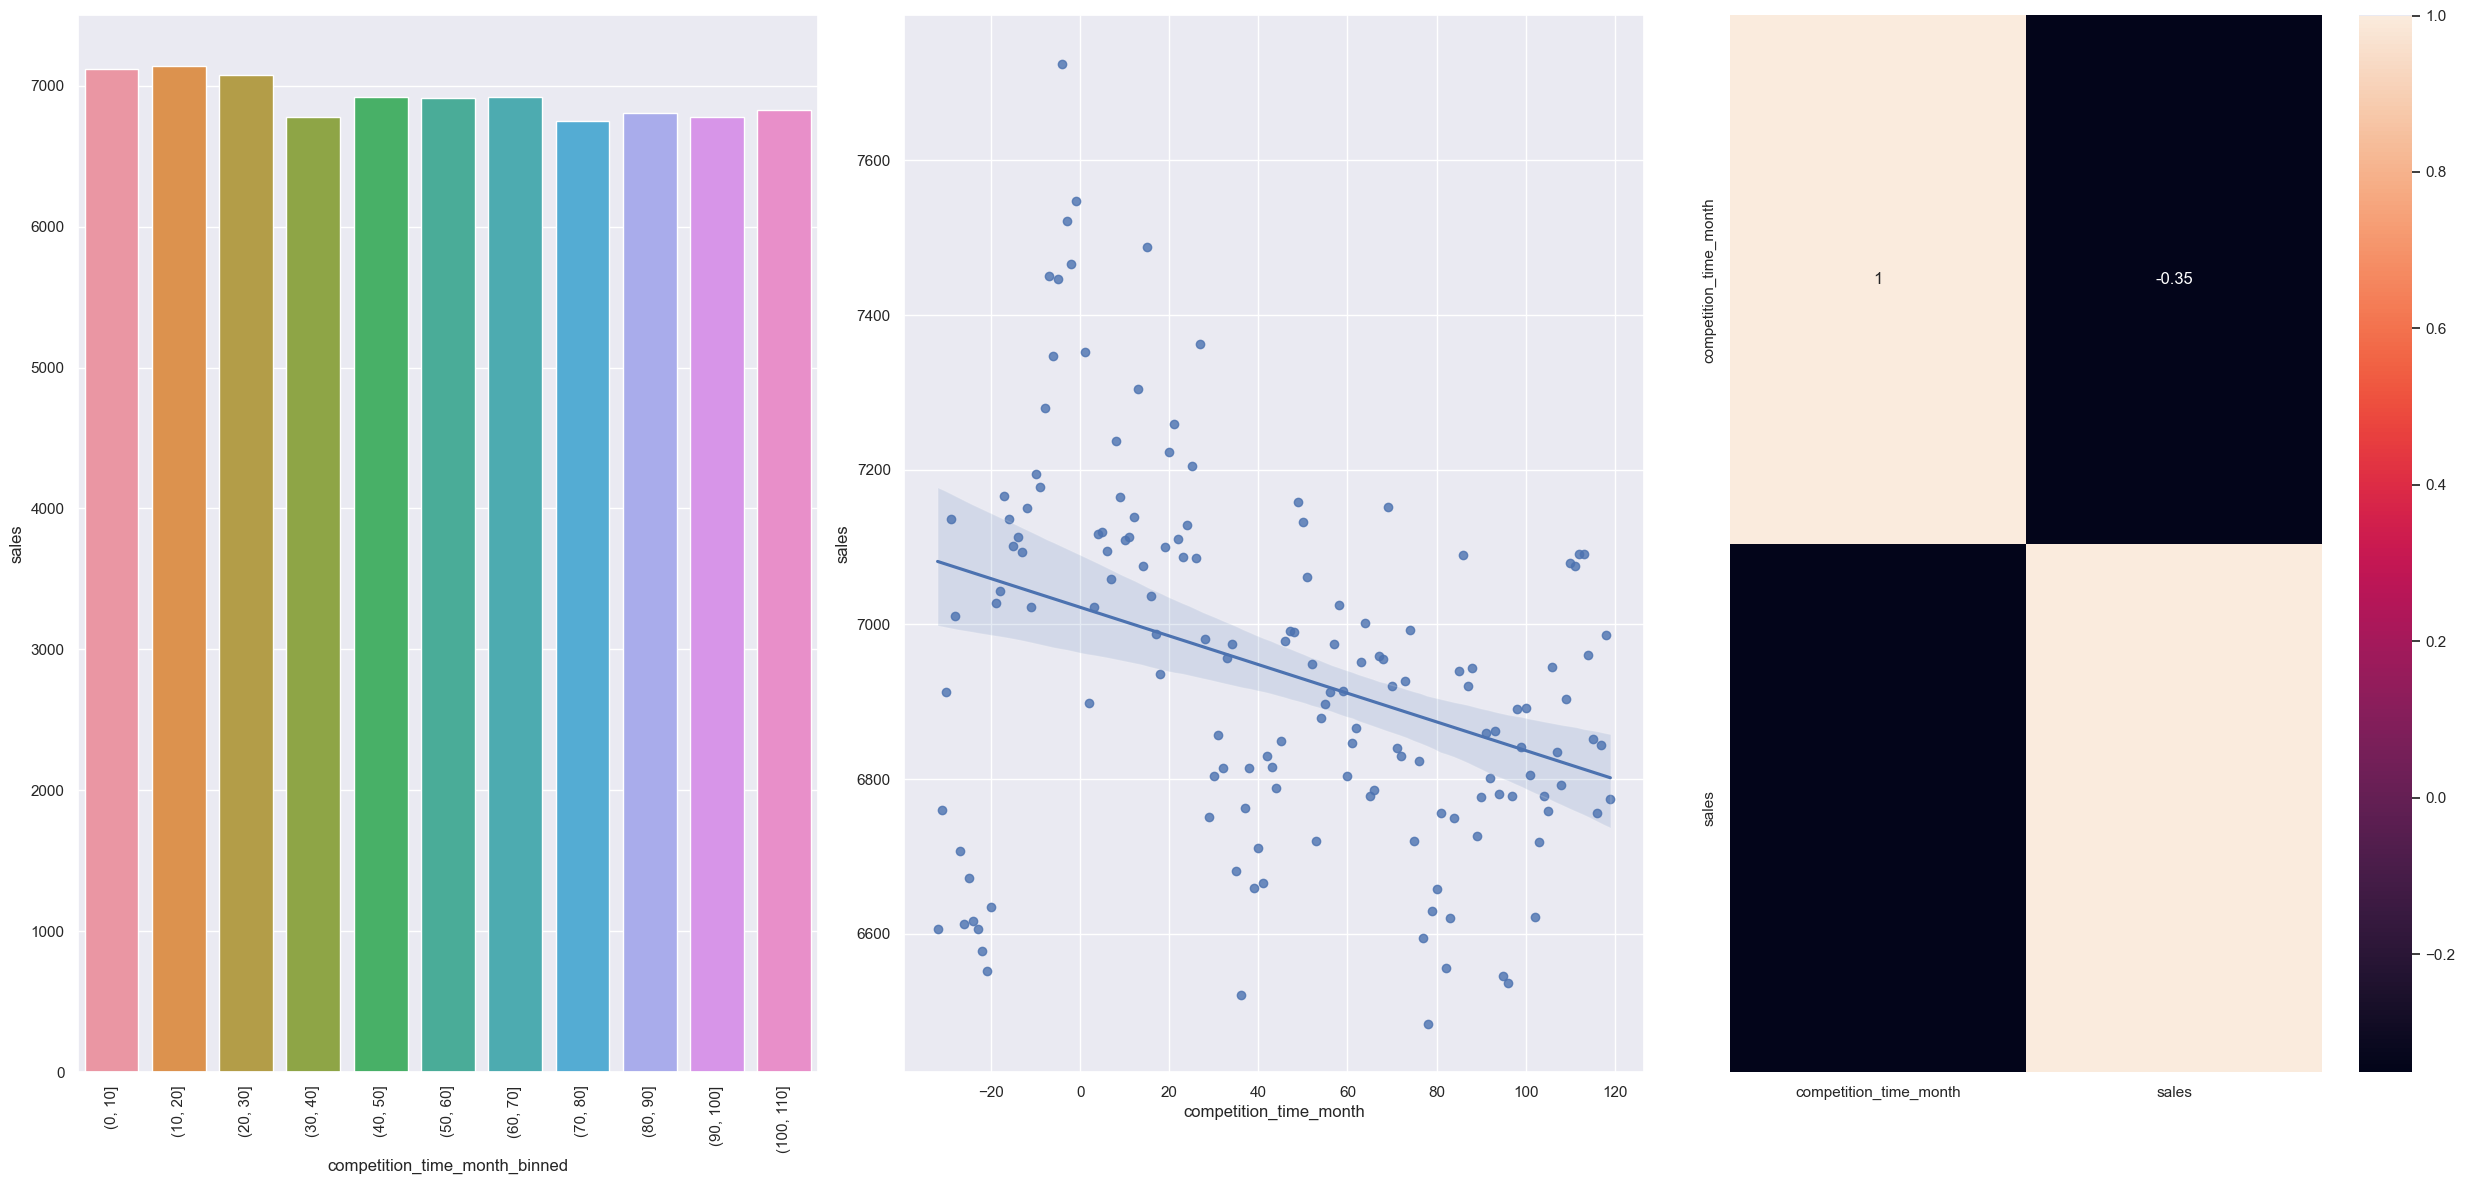

In [53]:
plt.subplot(1, 3, 1)

# 创建分区
bins = list(np.arange(0, 120, 10))  # 设置分区，从 0 到 120，间隔为 30
# 将 competition_time_month 分为 bins
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").mean().reset_index()

# 过滤数据，确保不超过120个月且不等于0
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]

# 分箱
aux2["competition_time_month_binned"] = pd.cut(aux2["competition_time_month"], bins=bins)

# 按分区计算平均销售额
aux3 = aux2[["competition_time_month_binned", "sales"]].groupby("competition_time_month_binned").mean().reset_index()

# 绘制条形图
sns.barplot(x="competition_time_month_binned", y="sales", data=aux3)
plt.xticks(rotation=90)

# 其他子图可以在这里添加...
plt.subplot(1, 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

plt.subplot(1, 3, 3)
aux2_numeric = aux2.select_dtypes(include=[np.number])
sns.heatmap(aux2_numeric.corr(method="pearson"), annot=True)

plt.tight_layout()
plt.show()

竞争对手存在时间更长的商店反而卖得更少

#### H4：有更多时间进行促销的商店应该卖得更多（√）

C:\Users\kong\AppData\Local\Temp\ipykernel_36580\4012048423.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2["promo_time_week_binned"] = pd.cut(aux2["promo_time_week"], bins=bins_1)
C:\Users\kong\AppData\Local\Temp\ipykernel_36580\4012048423.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux3 = aux2[["promo_time_week_binned", "sales"]].groupby("promo_time_week_binned").mean().reset_index()
D:\Programme\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True i

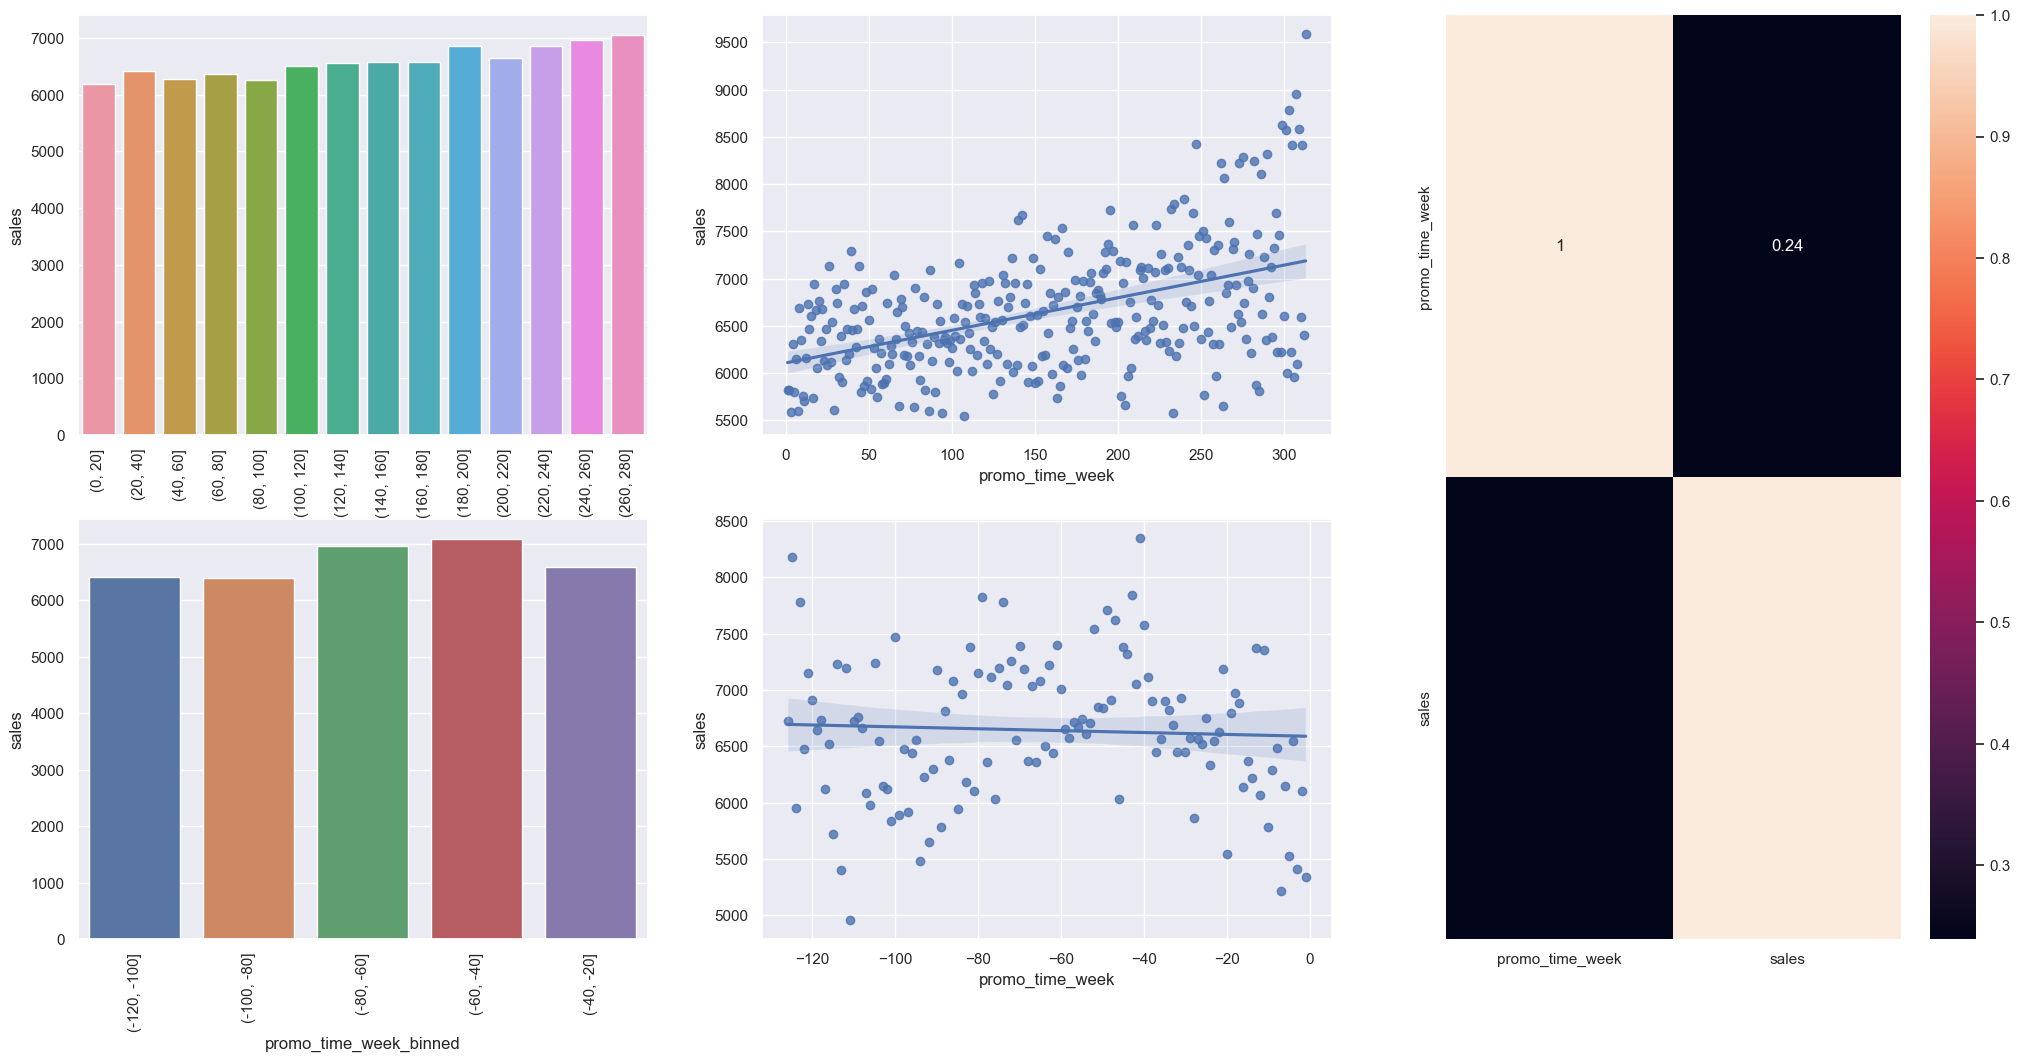

In [54]:
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").mean().reset_index()

grid = GridSpec(2, 3)
# 创建分区
bins_1 = list(np.arange(0, 300, 20))  # 设置分区，从 0 到 120，间隔为 30
bins_2 =  list(np.arange(-120, 0, 20))  # 设置分区，从 0 到 120，间隔为 30
plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo_time_week"] > 0] # promo extendida
aux2["promo_time_week_binned"] = pd.cut(aux2["promo_time_week"], bins=bins_1)
aux3 = aux2[["promo_time_week_binned", "sales"]].groupby("promo_time_week_binned").mean().reset_index()
# 绘制条形图
sns.barplot(x="promo_time_week_binned", y="sales", data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1, 0])
aux2 = aux1[aux1["promo_time_week"] < 0] # promo regular
aux2["promo_time_week_binned"] = pd.cut(aux2["promo_time_week"], bins=bins_2)
aux3 = aux2[["promo_time_week_binned", "sales"]].groupby("promo_time_week_binned").mean().reset_index()
# 绘制条形图
sns.barplot(x="promo_time_week_binned", y="sales", data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(), annot=True);

#### H5： 拥有更多连续促销的商店应该卖得更多（x）

In [55]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


promo2：连续促销 promo：当天促销 目前看起来当天促销对sales增长较大

#### H6：在圣诞节、复活节假期开放的商店应该卖得更多（√）

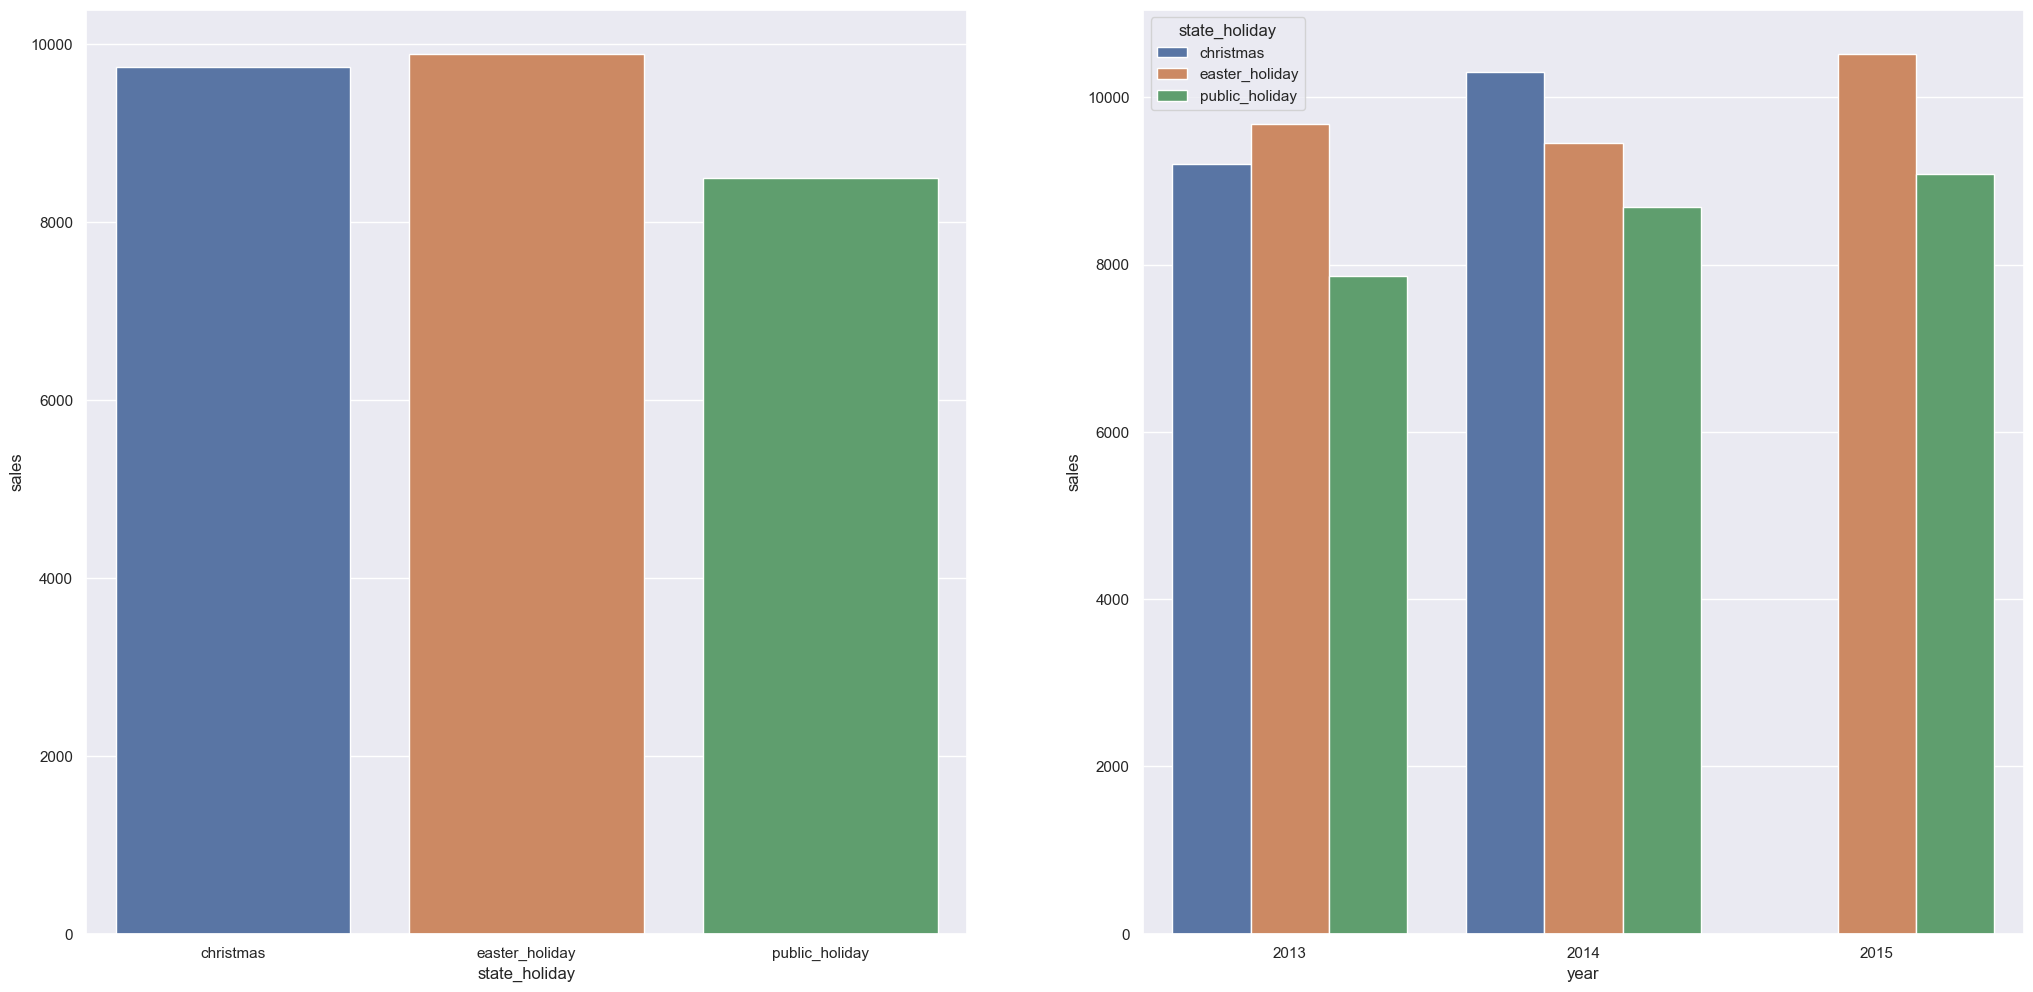

In [56]:
aux = df4[df4["state_holiday"] != "regular_day"]

plt.subplot(1, 2, 1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").mean().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).mean().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);

#### H7：商店应该随着时间的推移卖得更多（√）

<Axes: >

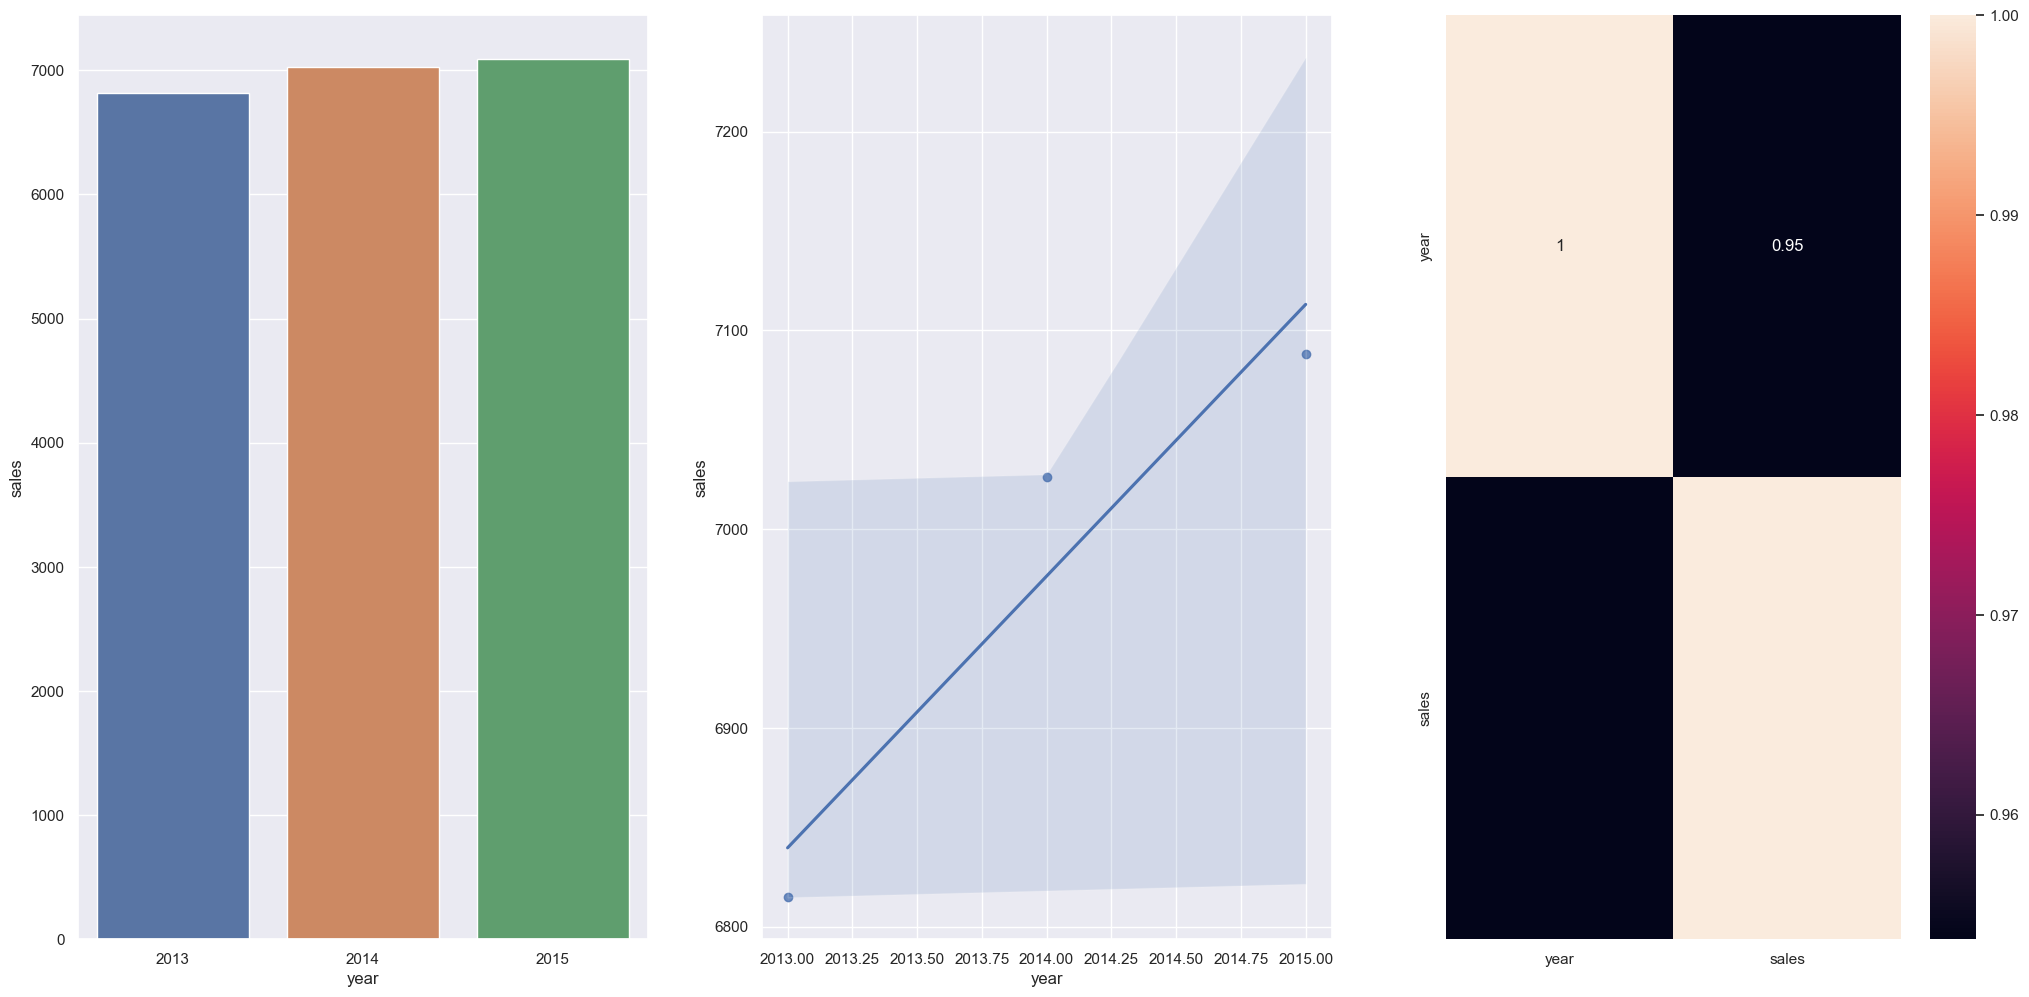

In [57]:
aux1 = df4[["year", "sales"]].groupby("year").mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="year", y="sales", data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x="year", y="sales", data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

#### H8：sales和月份存在关系（√）12月份销售额很多

<Axes: >

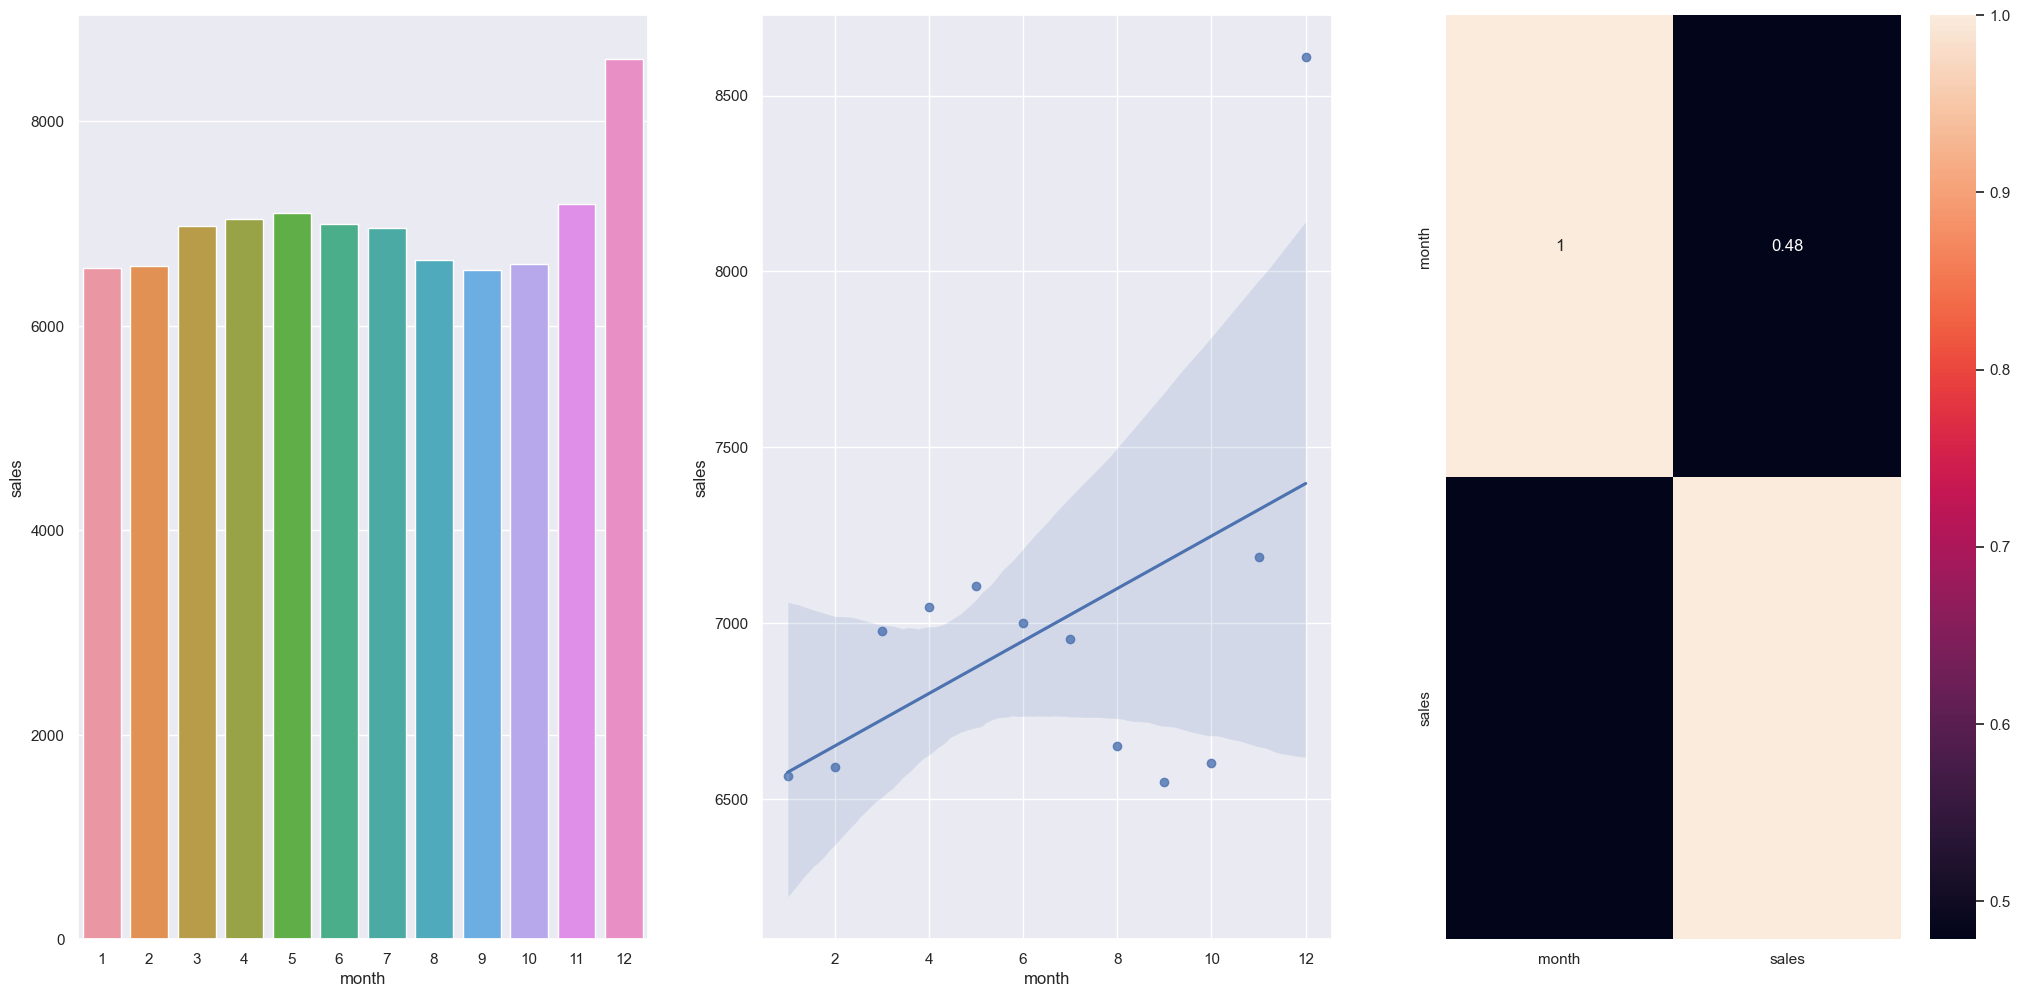

In [58]:
aux1 = df4[["month", "sales"]].groupby("month").mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="month", y="sales", data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x="month", y="sales", data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

#### H9：月初、月中、月末销售额偏多

<Axes: xlabel='before_after', ylabel='sales'>

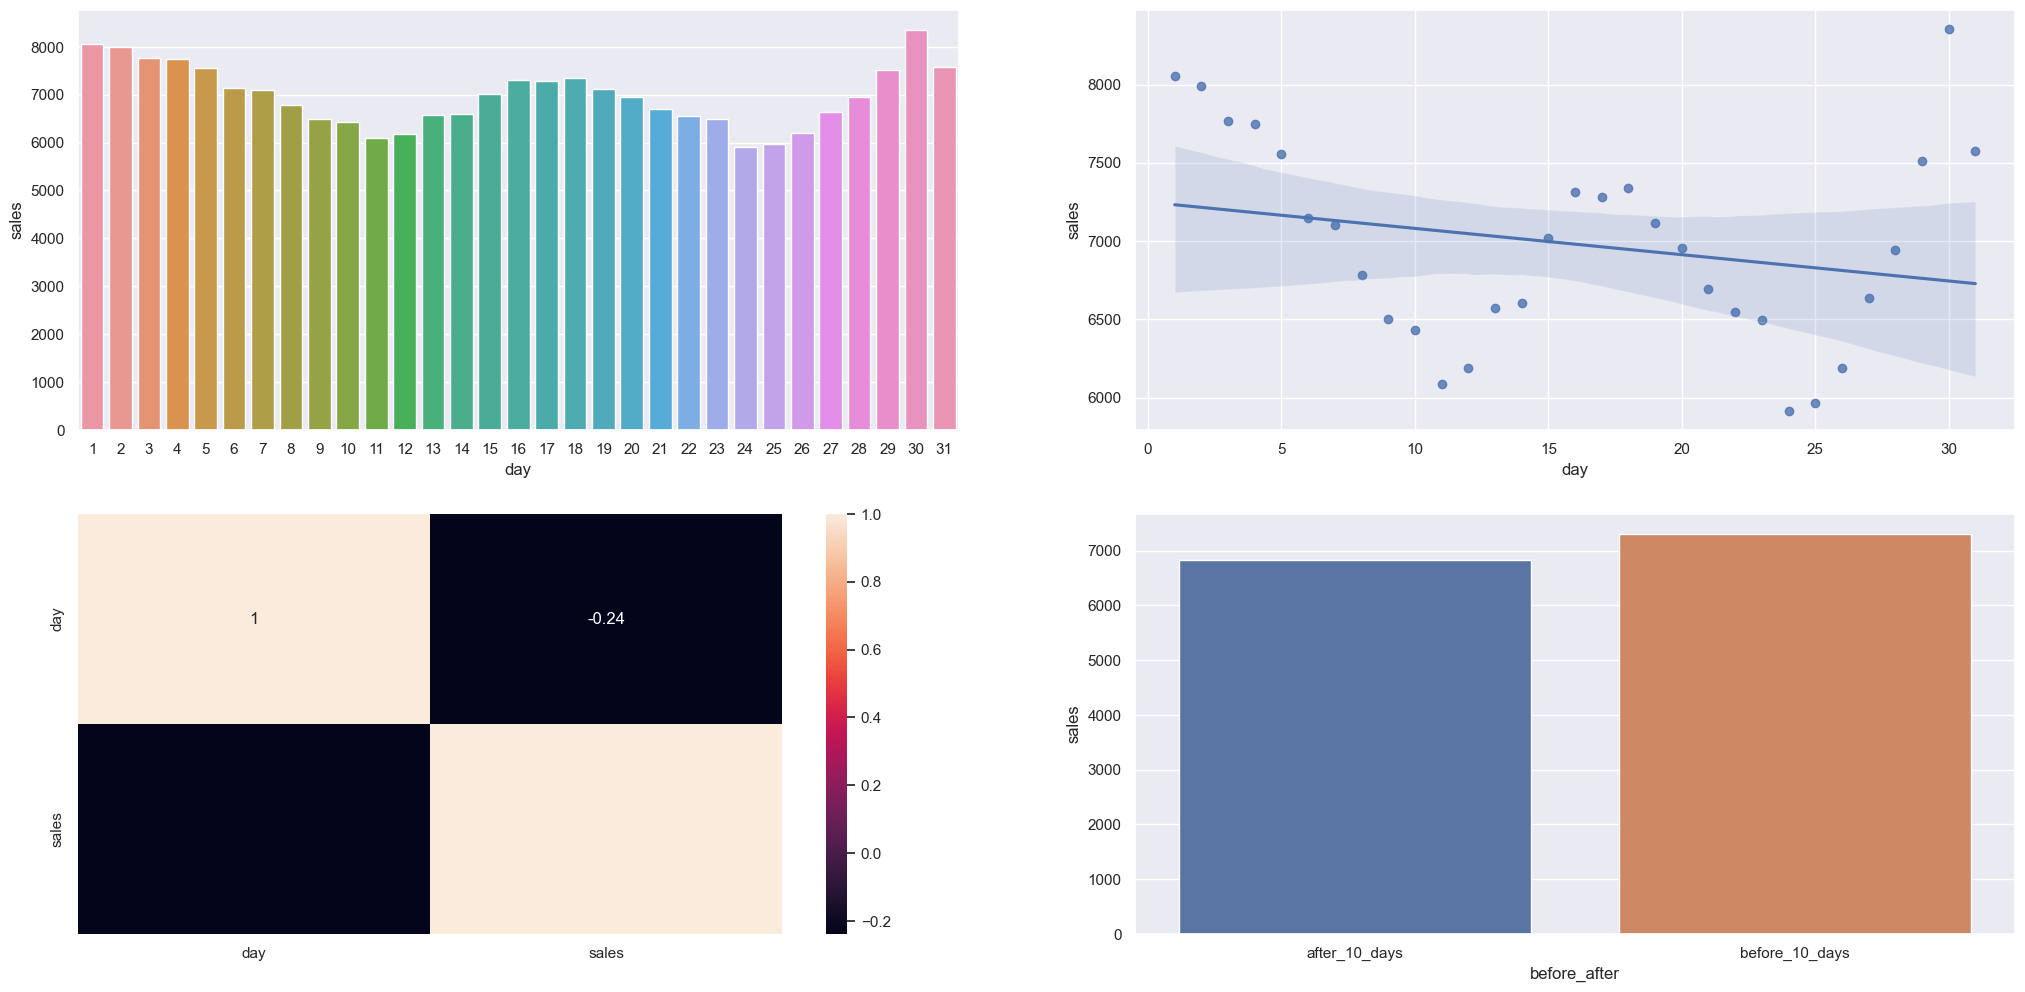

In [59]:
aux1 = df4[["day", "sales"]].groupby("day").mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x="day", y="sales", data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x="day", y="sales", data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True);

plt.subplot(2, 2, 4)
aux1["before_after"] = aux1["day"].apply(lambda x: "before_10_days" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after", "sales"]].groupby("before_after").mean().reset_index()
sns.barplot(x="before_after", y="sales", data=aux2)

#### H10：周一和周日销售额偏多

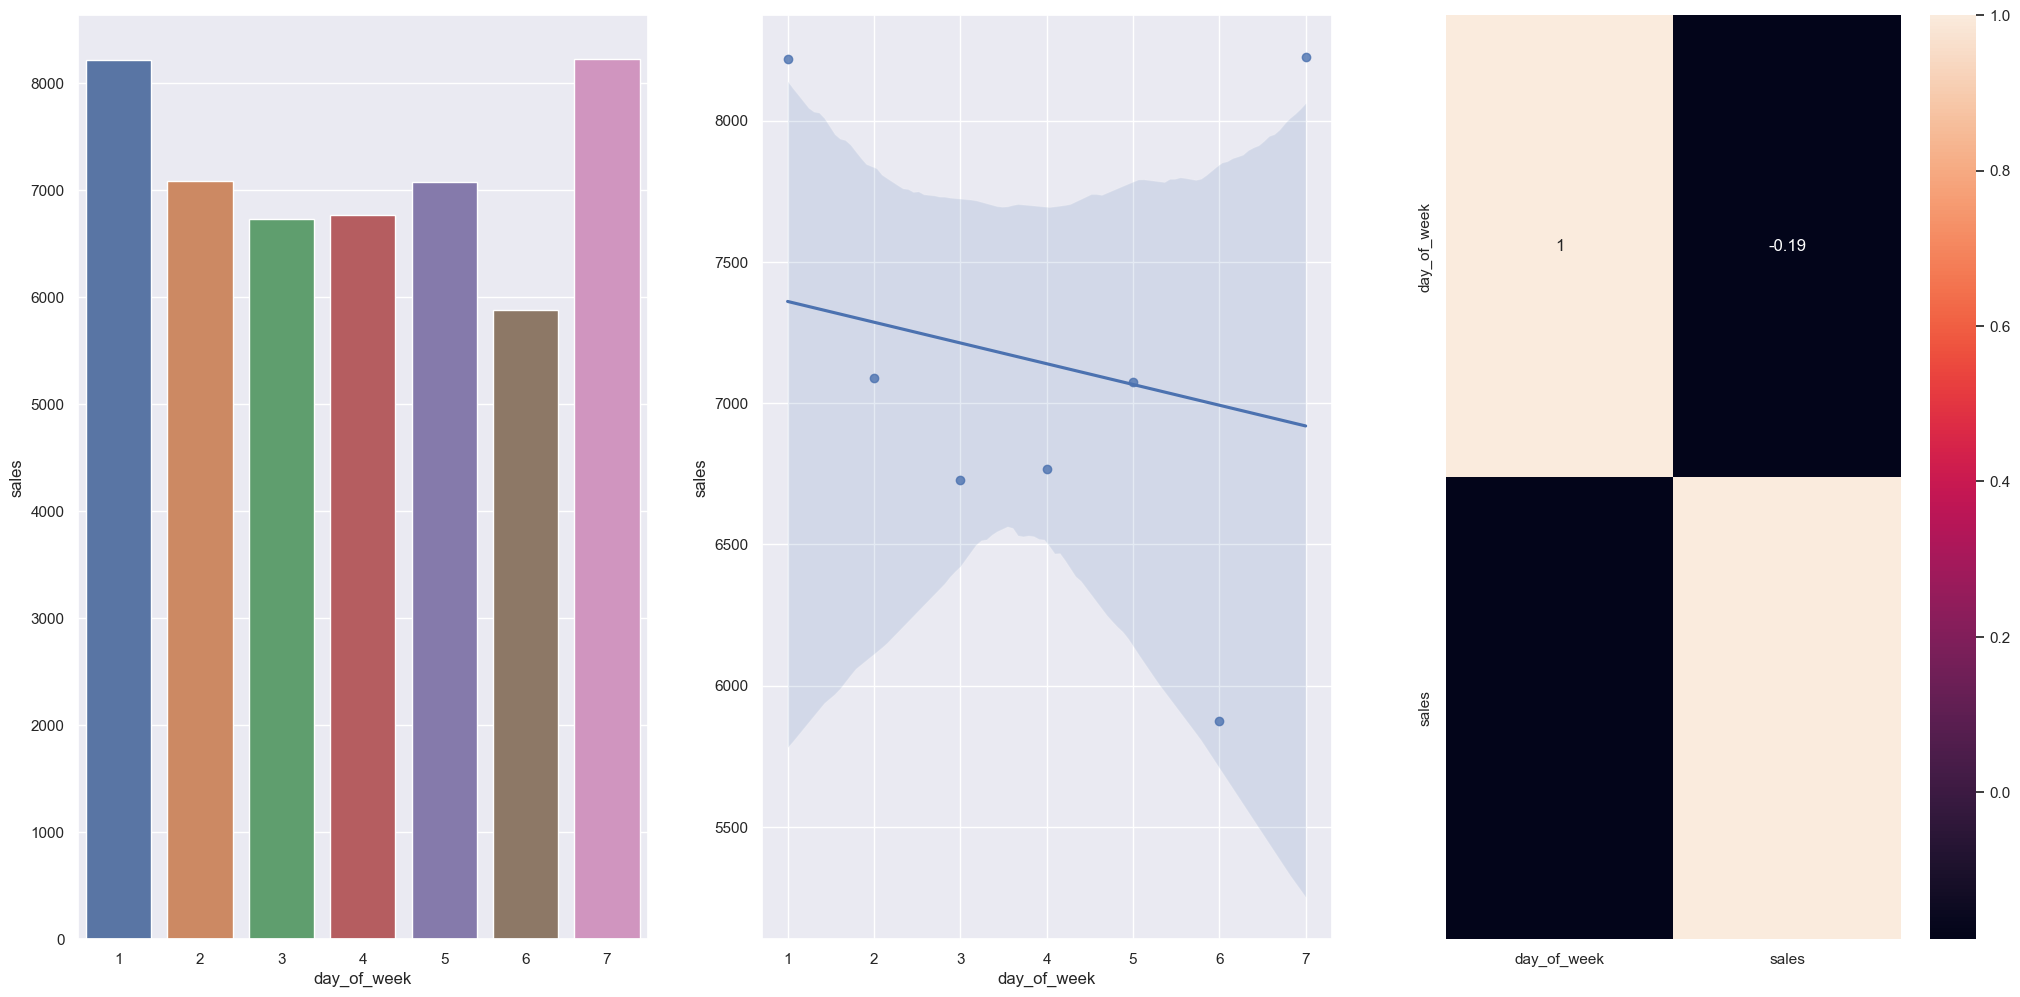

In [60]:
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x="day_of_week", y="sales", data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x="day_of_week", y="sales", data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

#### schoolholiday和sales有关系（x)

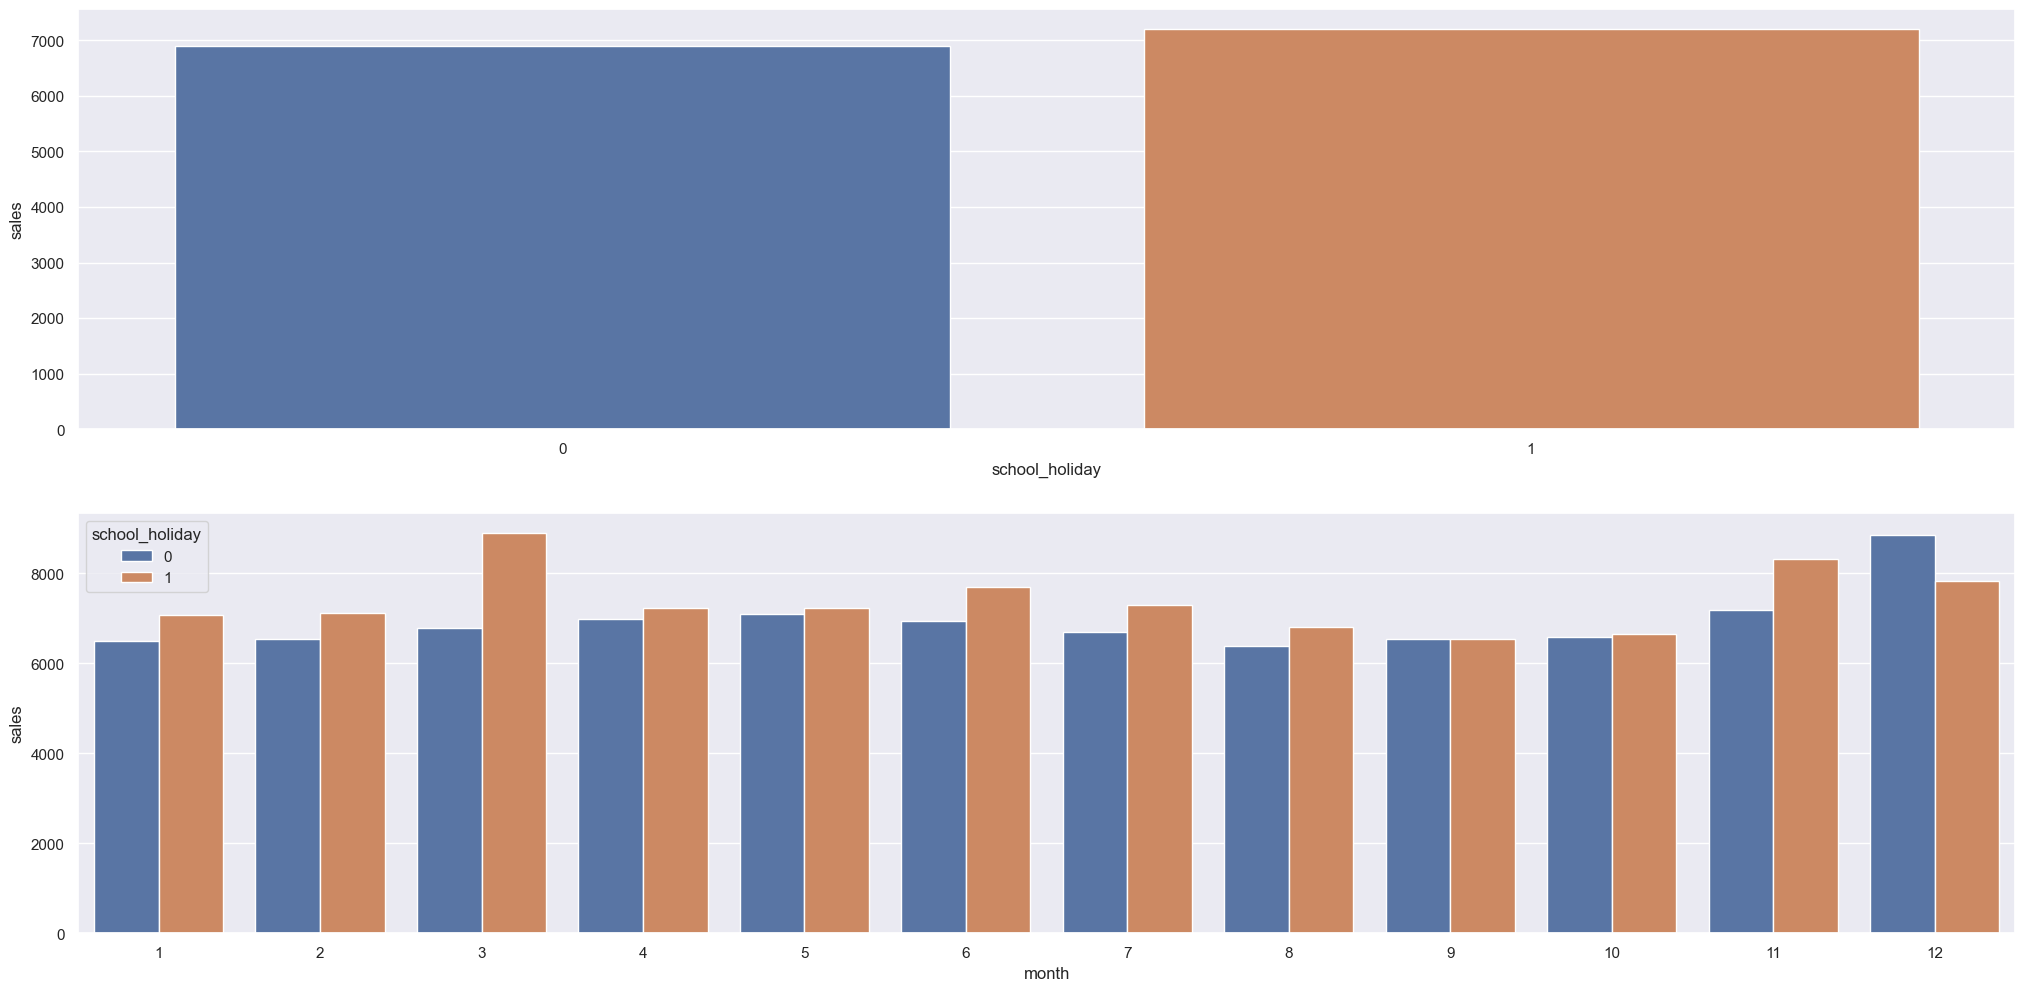

In [61]:
plt.subplot(2, 1, 1)
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").mean().reset_index()
sns.barplot(x="school_holiday", y="sales", data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[["month", "school_holiday", "sales"]].groupby(["school_holiday", "month"]).mean().reset_index()
sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2);

### 4.3相关性热图

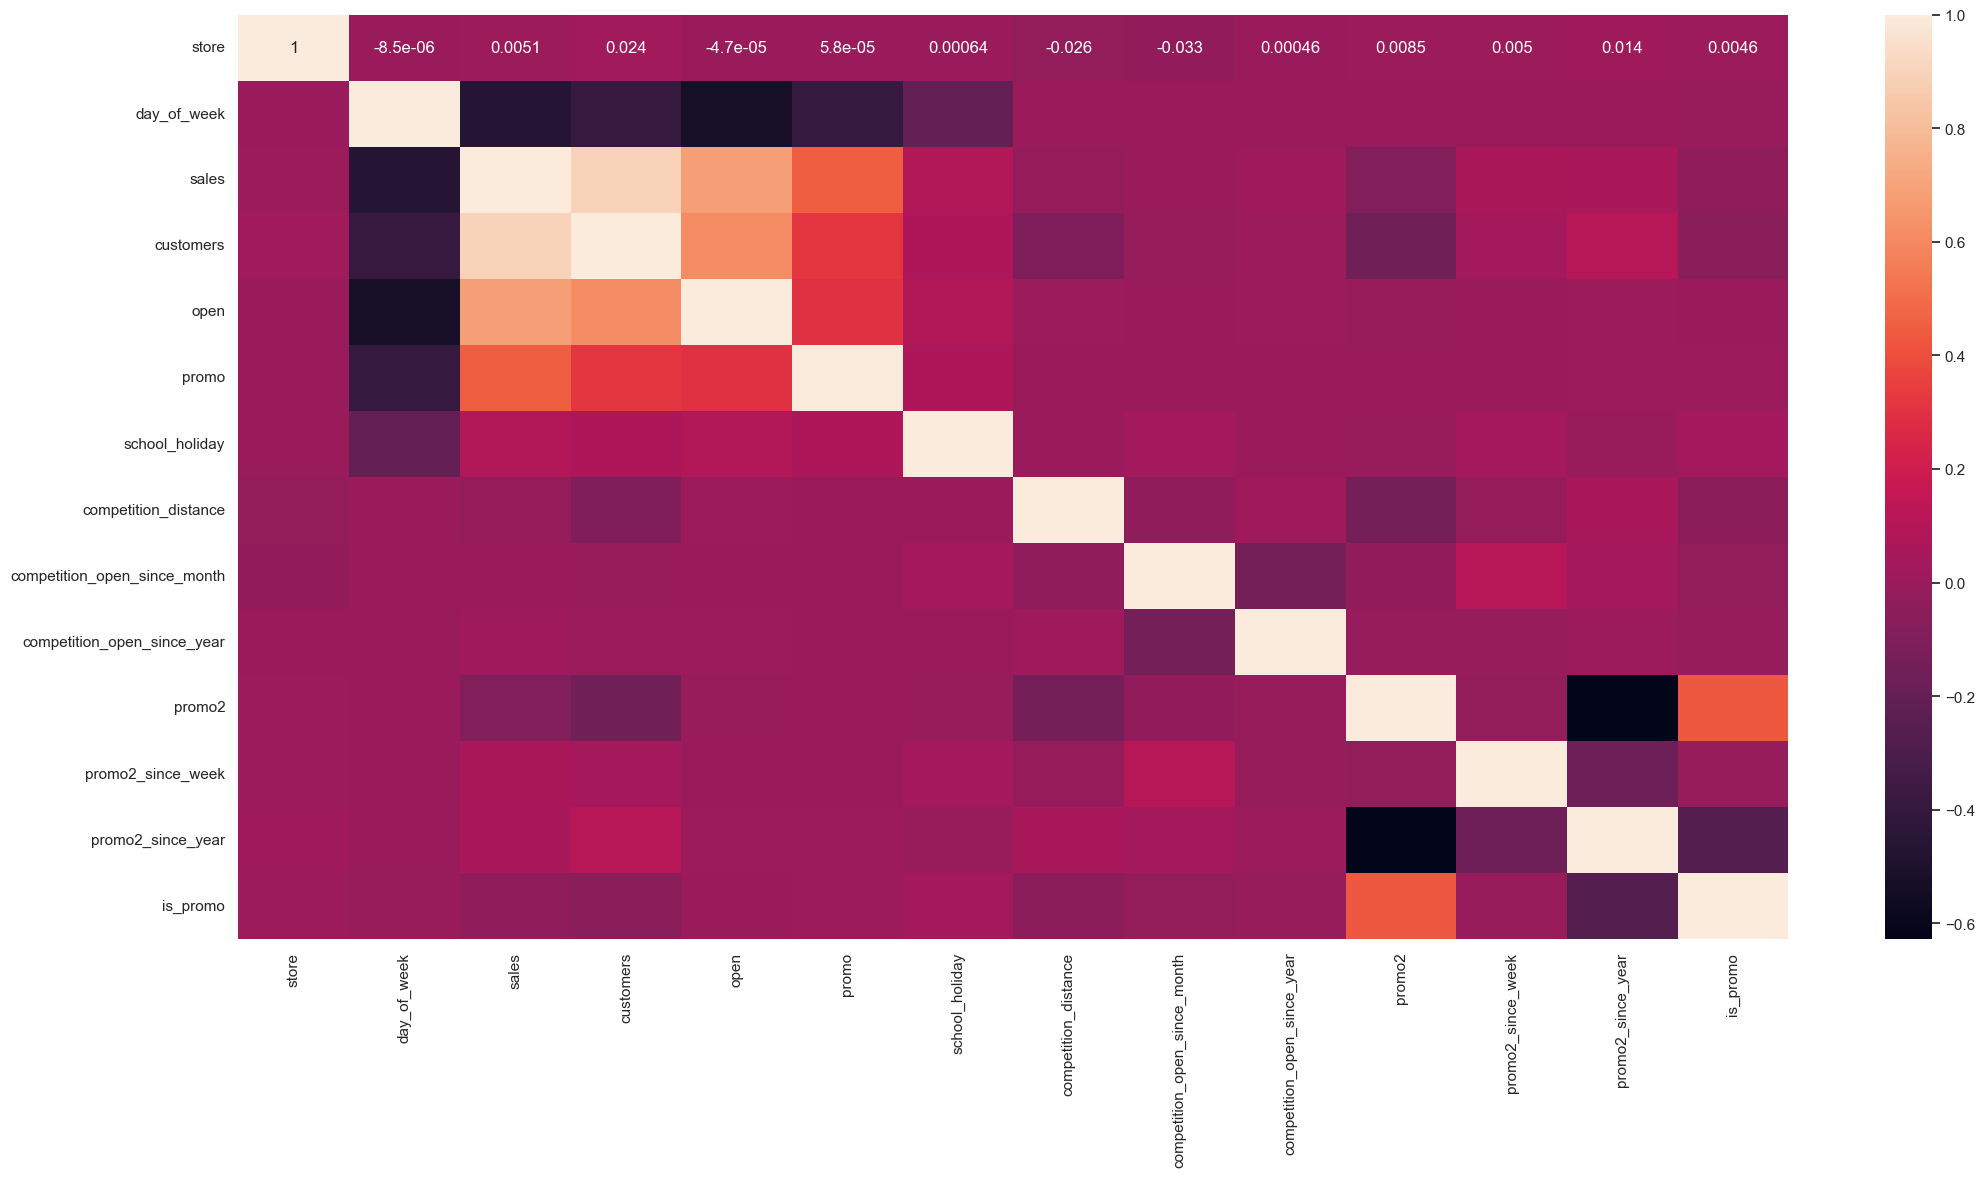

In [62]:
correlation = num_attributes.corr()
sns.heatmap(correlation, annot=True);

# 5.0 数据准备
## 5.1 归一化

In [63]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [64]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [65]:
a = df5.select_dtypes(include=["int64", "float64"])
a.head()

,store,day_of_week,sales,customers,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,29910.0,4,2015,0,31,2015,0


<Axes: xlabel='competition_distance'>

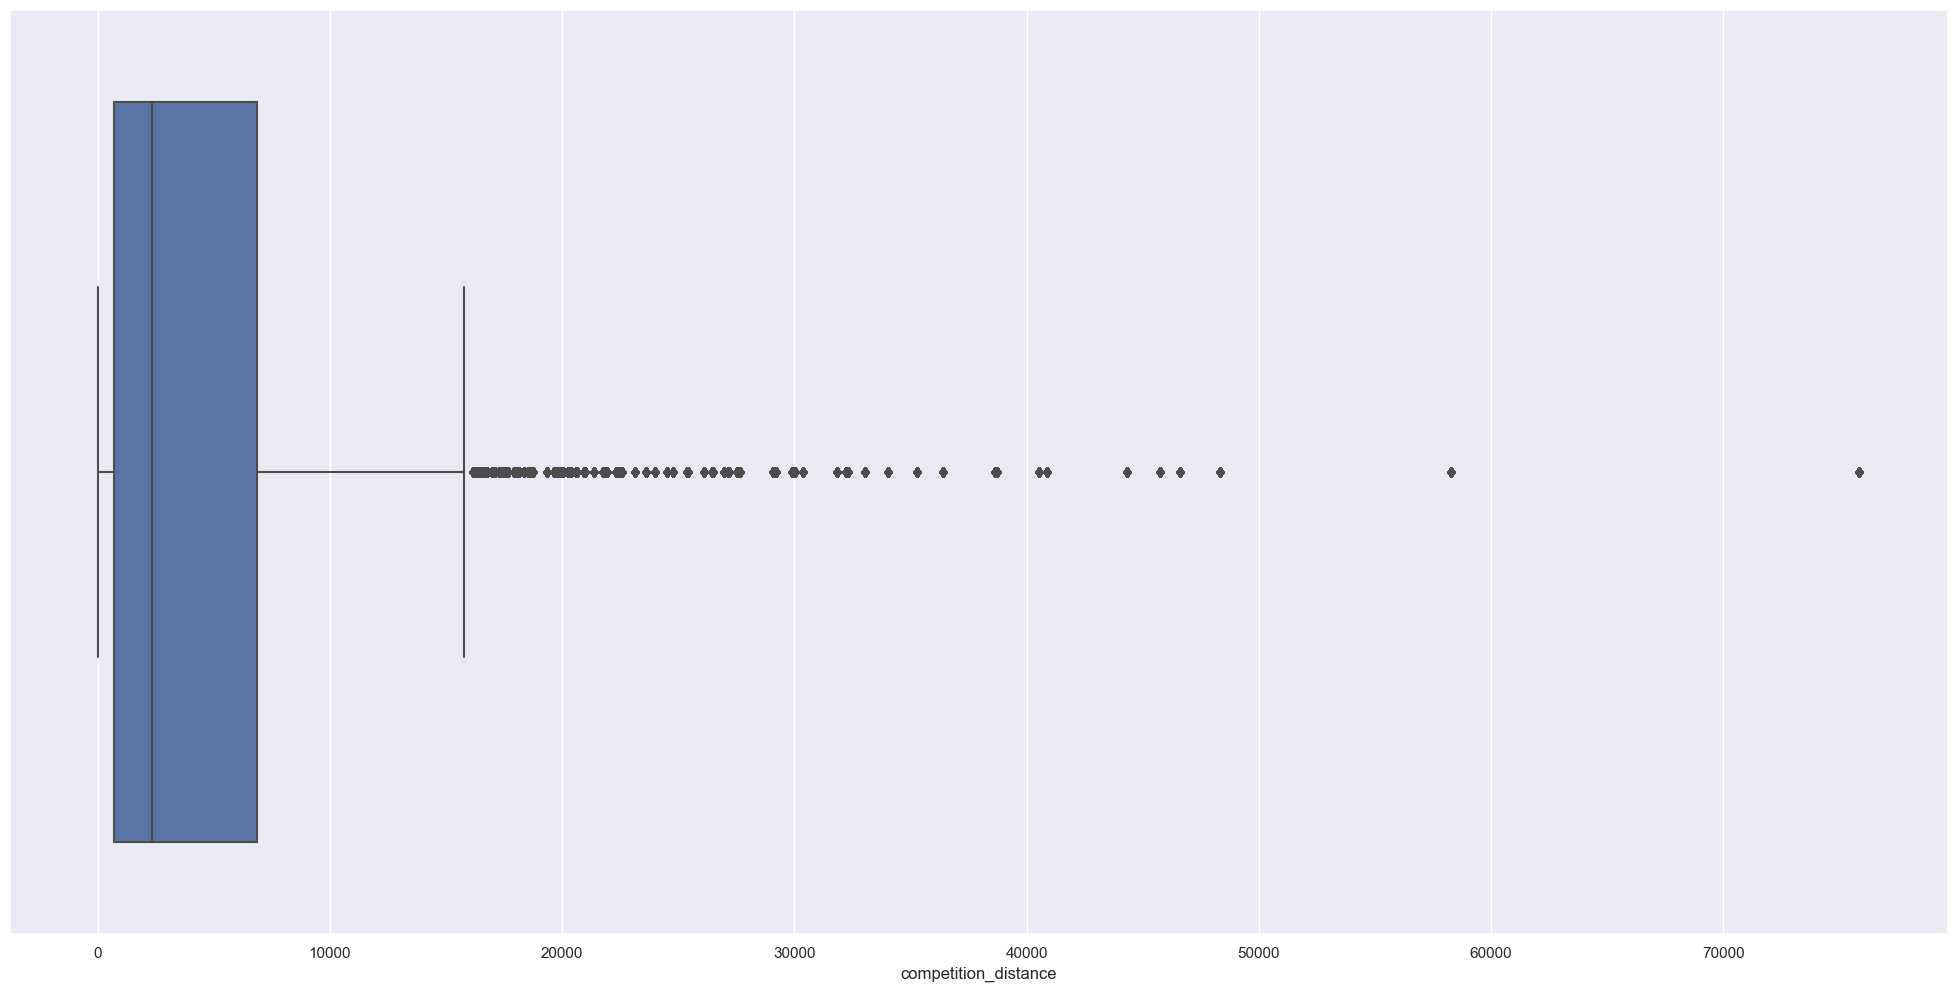

In [66]:
sns.boxplot(x="competition_distance", data=df5)

<Axes: xlabel='competition_time_month'>

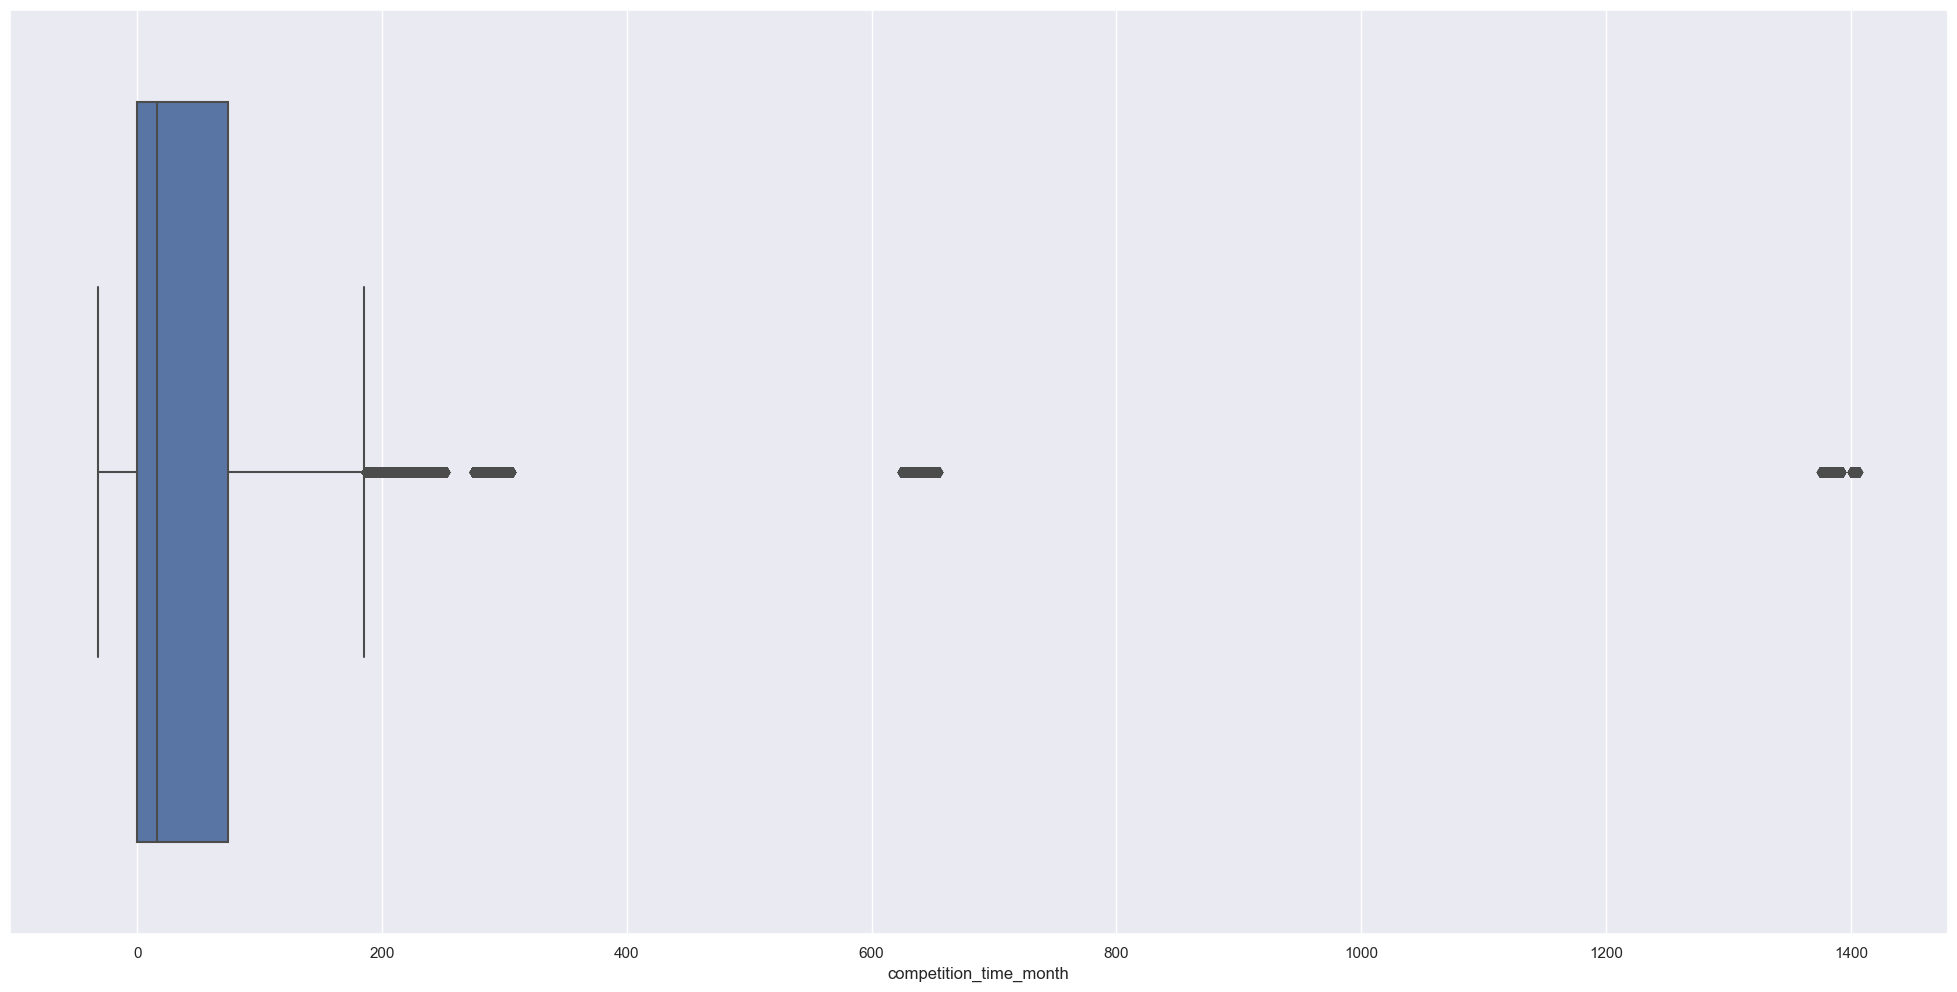

In [67]:
sns.boxplot(x="competition_time_month", data=df5)

<Axes: xlabel='promo_time_week'>

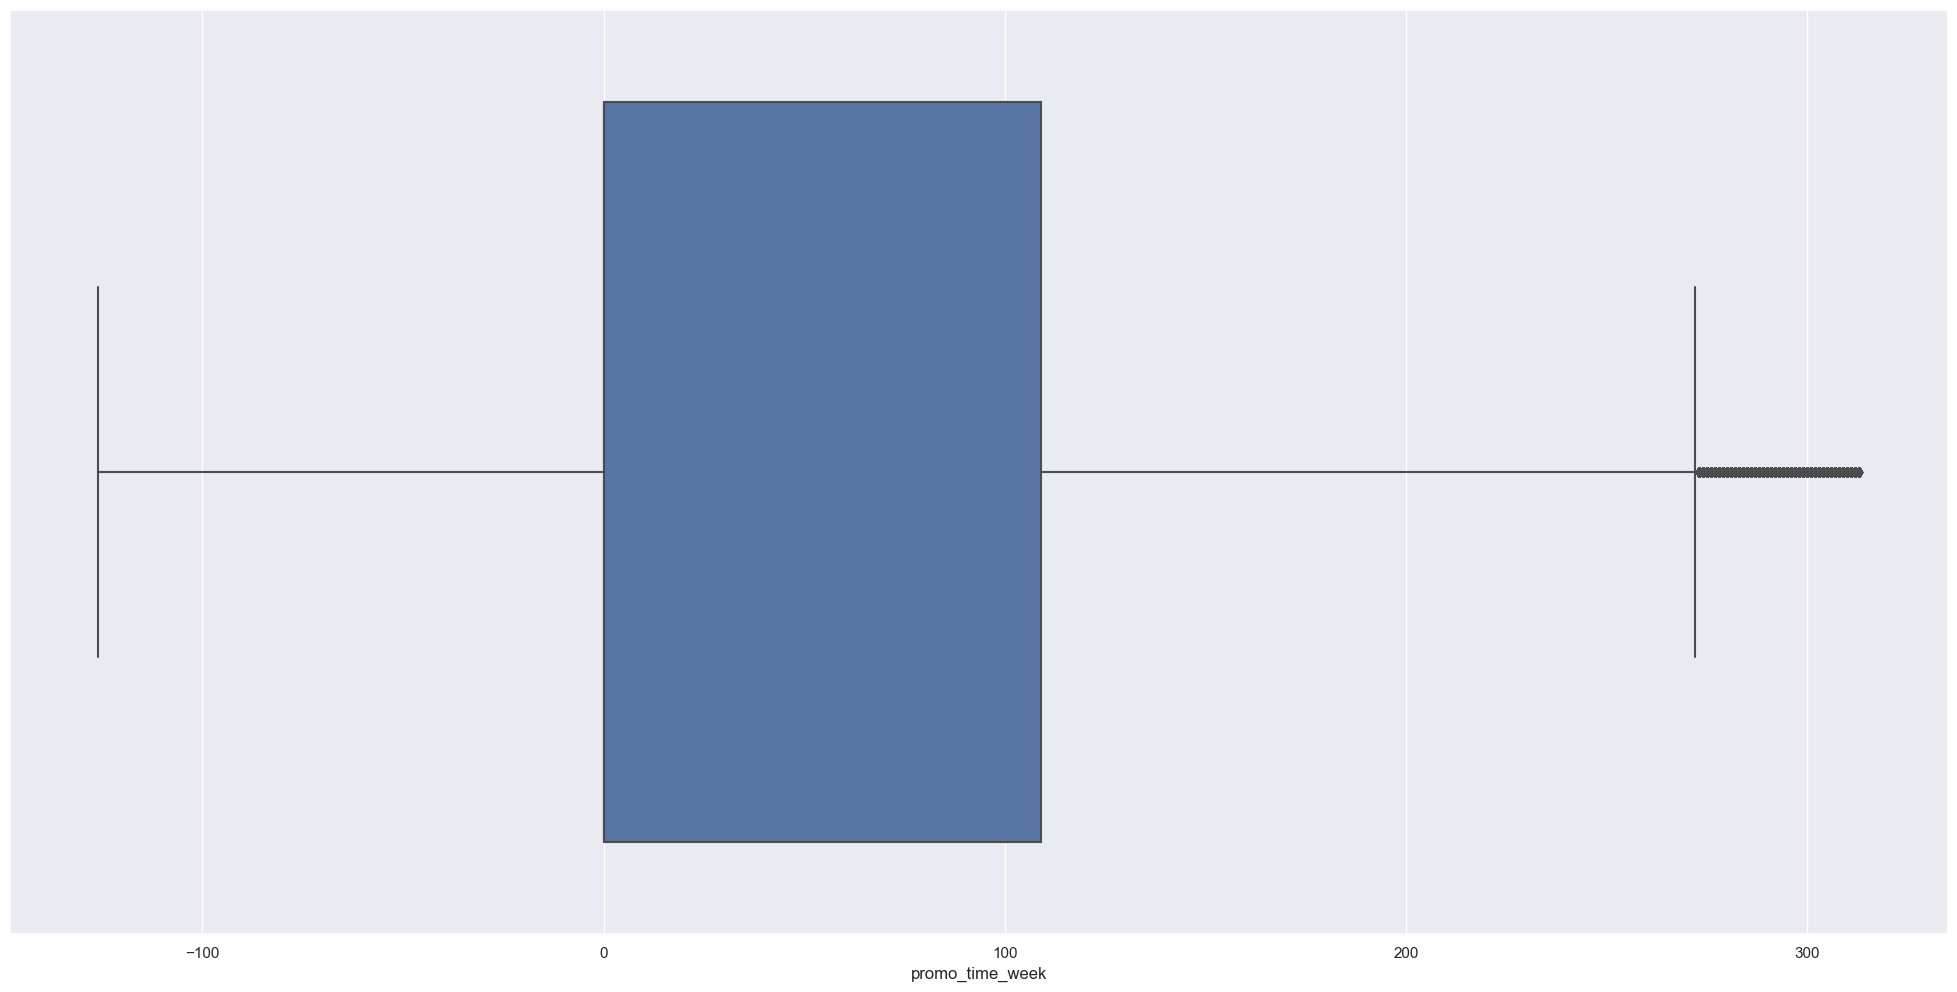

In [68]:
sns.boxplot(x="promo_time_week", data=df5)

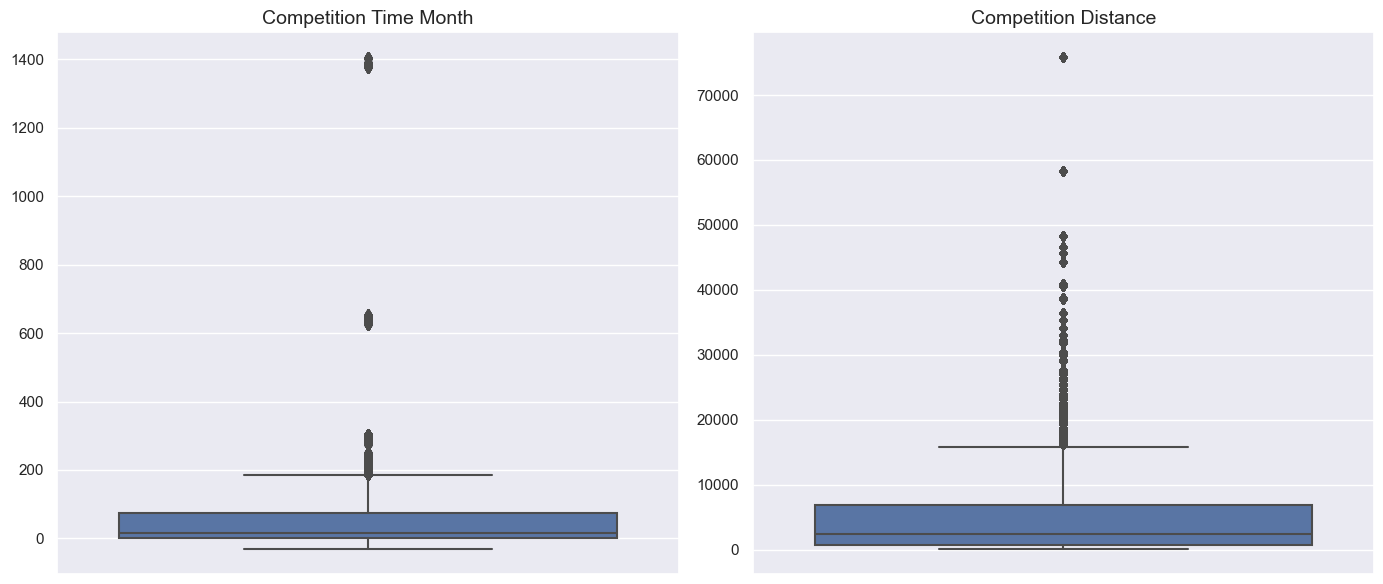

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个2行1列的子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 第一个箱型图
sns.boxplot(y="competition_time_month", data=df5, ax=axes[0])
axes[0].set_title('Competition Time Month',fontsize=14)
axes[0].set_ylabel('') 
# 第二个箱型图
sns.boxplot(y="competition_distance", data=df5, ax=axes[1])
axes[1].set_title('Competition Distance',fontsize=14)
axes[1].set_ylabel('') 
plt.tight_layout()  # 调整布局，避免重叠
plt.show()

#### promo_time_week和year偏态不严重，其余两个特征偏态严重且有离群值

In [70]:
import os

if not os.path.exists('../parameters'):
    os.makedirs('../parameters')

In [71]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)
dump(rs, "../parameters/competition_distance_scaler.joblib")

# year
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)
dump(mms, "../parameters/year_scaler.joblib")

# competition time month
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)
dump(rs, "../parameters/competition_time_month_scaler.joblib")

# promo time week
df5["year"] = mms.fit_transform(df5[["year"]].values)
dump(rs, "../parameters/promo_time_week_scaler.joblib")

['../parameters/promo_time_week_scaler.joblib']

## 5.2 特征编码

In [72]:
df5.head()

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,regular_day,1,c,basic,-0.171799,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,625,1,regular_day,1,a,basic,-0.285251,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,821,1,regular_day,1,a,basic,1.912480,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1498,1,regular_day,1,c,extended,-0.277147,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,559,1,regular_day,1,a,basic,4.470016,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [73]:
df5["state_holiday"].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [74]:
# state_holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"], dtype=int)

# store_type - Label Enconding
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])
dump(le, "../parameters/store_type_scaler.joblib")

# assortment - Ordinal Enconding
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df5["assortment"] = df5["assortment"].map(assortment_dict)

In [75]:
df5.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,2,1,-0.171799,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1,-0.285251,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1.912480,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,2,3,-0.277147,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,4.470016,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### One Hot Encoding (用于 state_holiday)：

适合处理分类特征，尤其是无序的类别。
将每个类别转换为一个二进制特征，使得每个类别都有独立的表示，不会引入任何顺序关系。这对于模型来说更清晰，避免了对模型的误导。

#### Label Encoding (用于 store_type)：

适合处理有序或类别较少的分类特征。
将每个类别转换为唯一的整数。这种方法虽然简单，但在某些情况下可能会引入类别之间的顺序关系，适用于存储类型这种可能有一定等级或关系的特征。

#### Ordinal Encoding (用于 assortment)：

适合处理有序的分类特征。
通过将类别映射到一个有意义的顺序（如1, 2, 3），使得模型可以理解类别之间的相对关系。这种编码方式适用于特征具有自然顺序的情况，例如不同类型的商品组合。

In [76]:
df5.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,2,1,-0.171799,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1,-0.285251,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1.912480,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,2,3,-0.277147,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,4.470016,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


对于一些feature的数据，如果偏度skewness大于0.5(有的要求大于0.75）,那么数据的分布更像是对数分布，通过对成对数分布的数据取log，数据会接近正态分布。log（XY）=logX+logY

In [77]:
df5["sales"] = np.log1p(df5["sales"])

In [78]:
df5.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,555,1,1,2,1,-0.171799,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,625,1,1,0,1,-0.285251,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,821,1,1,0,1,1.912480,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1498,1,1,2,3,-0.277147,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,559,1,1,0,1,4.470016,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


## 5.3 处理日期变量

In [79]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

关于日期的周期性编码参考：https://blog.csdn.net/qq_28327765/article/details/89186430

In [80]:
df5.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,555,1,1,2,1,-0.171799,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,625,1,1,0,1,-0.285251,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,821,1,1,0,1,1.912480,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1498,1,1,2,3,-0.277147,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,559,1,1,0,1,4.470016,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


### Note：之前在对不同数据集做数据预处理时，就经常使用相同的代码。在这里我把数据概览封装到一个类中，创建一个Data_Review类，其中包括数据加载、描述性统计、缺失值分析等功能。把这些功能封装成类的不同方法，功能模板化。

#### 类的功能说明：

__init__ 方法：初始化数据。

get_data_shape 方法：打印数据的行数和列数。

missing_values 方法：检查数据中的缺失值比例。

summary_statistics 方法：计算数值型特征的统计量（均值、标准差、最大值、最小值等）。

#### 优点：

复用性：轻松地对多个数据集应用同样的EDA过程。

扩展性：未来如果需要添加更多功能，比如数据可视化、异常值检测等，可以方便地在类中增加新的方法。

In [90]:
import pandas as pd
import numpy as np

class Data_Review:
    def __init__(self, data):
        self.data = data
        self.features = []

     
    def get_data_shape(self):
        """
        Get the shape of the dataframe.
        """
        print('The shape of Rows:', self.data.shape[0])
        print('The shape of Cols:', self.data.shape[1], '\n')

    def missing_values(self):
        """
        Analyze missing values in the dataset.
        """
        print("Missing Values:\n", self.data.isna().mean(), '\n')

    def summary_statistics(self):
        # Central Tendency - mean, median
        ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
        ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

        ## Dispersion - std, min, max, range, skew, kurtosis
        d1 = pd.DataFrame(num_attributes.apply(np.std)).T
        d2 = pd.DataFrame(num_attributes.apply(min)).T
        d3 = pd.DataFrame(num_attributes.apply(max)).T

        d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

        # Concatenate
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
        m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]
        print(m)
        
# Example usage
eda = EDA(df1) 
eda.get_data_shape()  
eda.missing_values()  
eda.summary_statistics() 

Data Shape: Rows = 1017209, Columns = 20 

Missing Values (%):
 store                           0.0
day_of_week                     0.0
date                            0.0
sales                           0.0
customers                       0.0
open                            0.0
promo                           0.0
state_holiday                   0.0
school_holiday                  0.0
store_type                      0.0
assortment                      0.0
competition_distance            0.0
competition_open_since_month    0.0
competition_open_since_year     0.0
promo2                          0.0
promo2_since_week               0.0
promo2_since_year               0.0
promo_interval                  0.0
month_map                       0.0
is_promo                        0.0
dtype: float64 

Summary Statistics:
               store   day_of_week                           date         sales     customers          open         promo  school_holiday  competition_distance  competition_open_s